In [329]:
'''Import all the necessary packages'''
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import Imputer, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
import xgboost
from sklearn import cross_validation as cv
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from patsy import dmatrix
from scipy import stats

import statsmodels.api as sm
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import requests
from bs4 import BeautifulSoup

import seaborn as sns
from statsmodels.graphics import utils

# 머신러닝 팀프로젝트 과제 발표

## 주제 : Shelter Animal Outcomes

#### DataSet

In [330]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

'''Keep a copy of the original data for comparison'''
data_original_train = data_train.copy()
data_original_test = data_test.copy()


In [346]:
#Train과 Test를 합쳐서 한번에 전처리 진행
#OutcomeSubtype은 Train에만 있는 데이터기 때문에 Drop
dfY = data_train['OutcomeType']
data_train_drop = data_train.drop('OutcomeSubtype', axis = 1)
data_train_drop.drop('OutcomeType', axis = 1, inplace = True)

data_test = data_test.rename(columns = {'ID':'AnimalID'})
data_combined = pd.concat([data_train_drop, data_test], axis = 0)
data_temp = data_combined.iloc[:26729, : ]

In [347]:
data_combined.head()

,AnimalID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [335]:
data_combined.tail()

,AnimalID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
11451,11452,NaN,2014-07-08 14:50,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black
11452,11453,NaN,2014-10-21 12:57,Cat,Intact Female,2 weeks,Domestic Shorthair Mix,Blue
11453,11454,NaN,2014-09-29 9:00,Cat,Intact Female,1 year,Domestic Shorthair Mix,Calico
11454,11455,Rambo,2015-09-05 17:16,Dog,Neutered Male,6 years,German Shepherd Mix,Black/Tan
11455,11456,Gusto,2014-07-12 18:40,Dog,Intact Male,4 years,Labrador Retriever,Cream


In [188]:
# 종속변수 Unique_Values 확인
data_train.OutcomeType.unique()

array(['Return_to_owner', 'Euthanasia', 'Adoption', 'Transfer', 'Died'], dtype=object)

# 개요


## 문제정의

**7개의 독립변수를 활용하여 보호소에 있는 각 동물이 종속변수의 5가지 유형 중 어느 것에 해당할 것인지 분류하는 문제.**

* 독립변수
 > Name : 발견당시 이름표 등에 표시되어 있던 이름. 주인이 지어준 것으로 예상됨.

 > DateTime : Outcome이 발생한 날짜와 시간.

 > AnimalType : 개와 고양이 두 종류.

 > SexuponOutcome : Outcome이 발생하는 시점에서의 해당 동물의 성별. 중성화 여부가 반영됨.

 > AgeuponOutcome : Outcome이 발생하는 시점에서의 해당 동물의 나이.

 > Breed : 해당 동물의 종. 

 > Color : 해당 동물의 색. 

* 종속변수 (**주인 찾아감 / 안락사 / 입양 / 타기관이송 / 사망**)



## 목표

**Log-Loss 의 최소화**

## 분석설계

#### 1. EDA
  1) Name

  2) DateTime

  3) AnimalType

  4) SexuponOutcome

  5) AgeuponOutcome

  6) Breed

  7) Color

* One-Hot-Encoding

#### 2. Feature Selection
* Greedy Search

#### 3. Modeling
* Logistic Regression Model
* Naive Bayesian Model
* Random Forest Model
* Extreme Forest Model
* XG-boost Model

#### 4. Model Selection
* XG-boost Model

#### 5. Kaggle 결과값 논란



# EDA

## Nan_value

In [337]:
def graph_na(data_train):
    plt.figure()
    missing_data_count = data_train.isnull().sum()
    missing_data_count.sort_values(ascending = False, inplace = True)
    missing_data_count_filtered = missing_data_count[missing_data_count > 0]
    missing_data_count_filtered.plot(kind = 'bar', title = 'missing data count')
    plt.show()

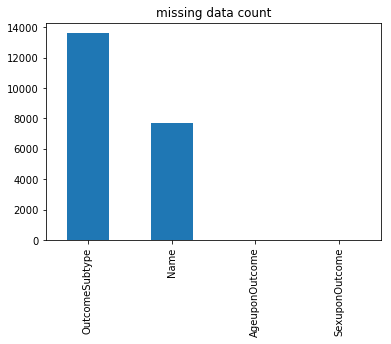

In [338]:
graph_na(data_train)

In [339]:
data_train.isnull().sum()

AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

In [340]:
data_test.isnull().sum()

AnimalID             0
Name              3225
DateTime             0
AnimalType           0
SexuponOutcome       0
AgeuponOutcome       6
Breed                0
Color                0
dtype: int64

In [341]:
data_combined.isnull().sum()

AnimalID              0
Name              10916
DateTime              0
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       24
Breed                 0
Color                 0
dtype: int64

#### Name -> 유/무에 따라 해당 동물에 대한 주인의 애착 정도를 반영한다고 추측함. 따라서 유/무에 따른 결과값 분석 필요
#### OutcomeSubtype -> OutcomeType과 직관적으로 연결된 인자 (데이터 분석에는 적용 x)
#### AgeUponOutcome 의 NaN 값은 Median으로 처리
#### SexuponOutcome 의 NaN값은 'Unknown'으로 처리

## 종속변수

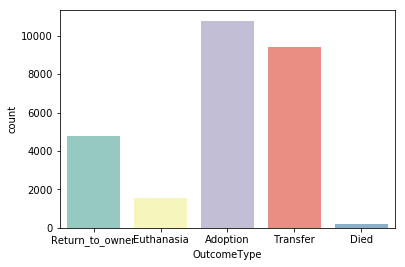

In [342]:
sns.countplot(data_train.OutcomeType, palette='Set3')
plt.show()

## 독립변수

### 1. Name

In [343]:
# Name 안에 있는 unique 갯수
data_train.Name.nunique()

6374

In [350]:
# 이름이 있는 경우 -> 'Name' / 이름이 없는 경우 -> 'No Name' 으로 변경

def no_name_label(x):
    '''Reference: https://github.com/JihongL/Shelter-Animal-Outcomes/blob/master/Shelter_EDA.ipynb'''
    if type(x) == float:
        return 'No Name'
    else:
        return 'Name'
    
data_combined['Name'] = data_combined['Name'].transform(no_name_label)
data_train['Name'] = data_train['Name'].transform(no_name_label)

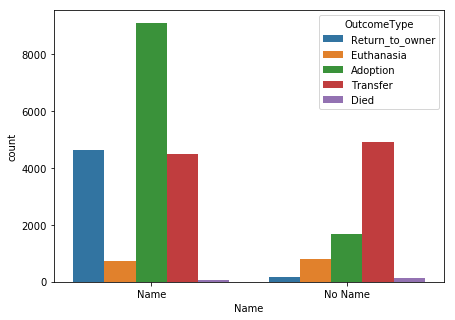

In [351]:
#이름 유/무와 OutcomeType 관계 그래프
plt.figure(figsize = (7, 5))
sns.countplot(x = 'Name', hue = 'OutcomeType', data = data_train)
plt.show()

#### 이름이 있는 경우에 주인이 찾아가는 비율이 압도적으로 높았는데, 이는 이름의 유무가 주인의 애착정도를 반영할 것이라는 애측이 타당했음을 증명한다고 보여짐.
#### 또한 이름이 있는 경우 입양되는 비율도 높았는데, 이는 이름이 있다는 것이 입양자에게 이 애완견(묘)이 이전 주인에게 사랑받고 키워졌다는 신호로 작용했을 것이라 추측함.

### 2. Date Time

In [352]:
# 날짜 데이터에서 년, 월, 일, 시간 자료 추출 및 계절 변수 형성

def datetime_str_converter(data_train):
    '''This method converts the datetime input into year and month in
    string format. The below method is identical except it returns numerical
    value. The string format is used for graphing with countplot'''
    datetime = list(data_train['DateTime'])
    year_list, month_list, day_list, hour_list = [], [], [], []
    for item in datetime:
        year_list.append(item[:4])
        month_list.append(item[5:7])
        day_list.append(item[8:10])
        hour_list.append(item[11:13])
    return year_list, month_list, day_list, hour_list

def season_sort(month_list):
    '''Converts month information to season information'''
    season_list = []
    for item in month_list:
        item = int(item)
        if item == 12 or item == 1 or item == 2:
            season_list.append('winter')
        elif item >=3 and item <=5:
            season_list.append('spring')
        elif item >= 6 and item <= 8:
            season_list.append('summer')
        elif item >= 9 and item <= 11:
            season_list.append('fall')
    return season_list

In [354]:
'''Year and Month information extraction'''
year_list, month_list, day_list, hour_list = datetime_str_converter(data_train)
date_list = []
for year, month in zip(year_list, month_list):
    date_list.append(int(year + month))

#Data를 년, 월, 일, 시간 그리고 년 + 월 합친 데이터로 변환 in train
data_train['Date'] = date_list
data_train['OutcomeYear'], data_train['OutcomeMonth'] = year_list, month_list
data_train['OutcomeDay'], data_train['OutcomeHour'] = day_list, hour_list



#계절 데이터 형성 in train
season_list = season_sort(month_list)
data_train['OutcomeSeason'] = season_list


In [197]:
#Data 확인
data_train.tail()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason
26724,A702446,No Name,2015-05-14 11:56:00,Transfer,Partner,Cat,Intact Male,1 month,Domestic Shorthair Mix,Brown Tabby/White,201505,2015,05,14,11,spring
26725,A718934,No Name,2016-01-20 18:59:00,Transfer,SCRP,Cat,Spayed Female,3 months,Domestic Shorthair Mix,Brown Tabby,201601,2016,01,20,18,winter
26726,A698128,Name,2015-03-09 13:33:00,Adoption,NaN,Dog,Neutered Male,4 years,Old English Bulldog Mix,White/Tan,201503,2015,03,09,13,spring
26727,A677478,No Name,2014-04-27 12:22:00,Transfer,Partner,Cat,Intact Male,4 weeks,Domestic Shorthair Mix,Black,201404,2014,04,27,12,spring
26728,A706629,No Name,2015-07-02 09:00:00,Transfer,SCRP,Cat,Intact Male,1 year,Domestic Shorthair Mix,Brown Tabby/White,201507,2015,07,02,09,summer


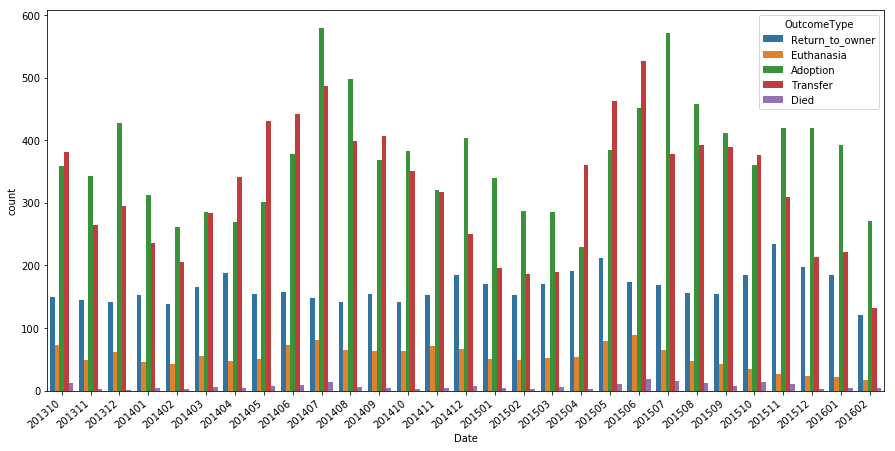

In [198]:
#날짜와 결과값 관계 그래프
fig, ax = plt.subplots(figsize=(15, 7))
ax = sns.countplot(x = 'Date', hue = 'OutcomeType', data = data_train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

#### 보기 매우 피곤한 그래프이기 때문에 위 Reference에서 나온 factorplot 이용하여 새로운 plot형성

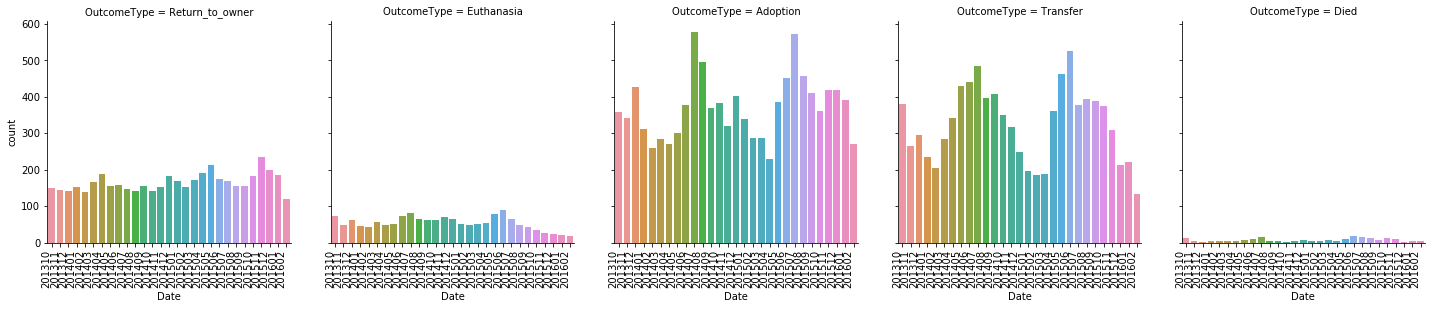

In [199]:
plt.figure(figsize=(20,20))
ax2 = sns.factorplot(x = 'Date', col = 'OutcomeType', data = data_train, kind = 'count')
ax2.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.show()

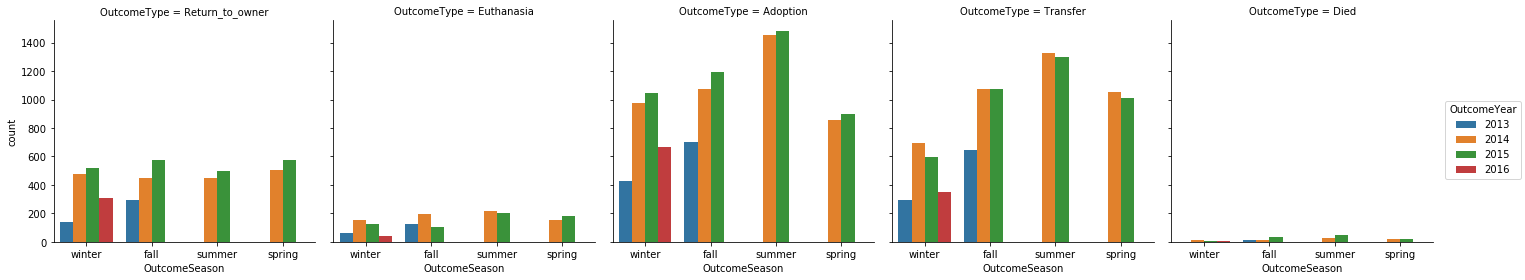

In [200]:
#계절별 OutcomeType 관계 그래프
sns.factorplot(x = 'OutcomeSeason', hue = 'OutcomeYear', col = 'OutcomeType', data = data_train, kind = 'count')
plt.show()

분석을 위해 data_combined 에도 변수변환작업

In [355]:
def datetime_str_converter(data_combined):
    '''This method converts the datetime input into year and month in
    string format. The below method is identical except it returns numerical
    value. The string format is used for graphing with countplot'''
    datetime = list(data_combined['DateTime'])
    year_list, month_list, day_list, hour_list = [], [], [], []
    for item in datetime:
        year_list.append(item[:4])
        month_list.append(item[5:7])
        day_list.append(item[8:10])
        hour_list.append(item[11:13])
    return year_list, month_list, day_list, hour_list

def season_sort(month_list):
    '''Converts month information to season information'''
    season_list = []
    for item in month_list:
        item = int(item)
        if item == 12 or item == 1 or item == 2:
            season_list.append('winter')
        elif item >=3 and item <=5:
            season_list.append('spring')
        elif item >= 6 and item <= 8:
            season_list.append('summer')
        elif item >= 9 and item <= 11:
            season_list.append('fall')
    return season_list

In [356]:
'''Year and Month information extraction'''
year_list, month_list, day_list, hour_list = datetime_str_converter(data_combined)
date_list = []
for year, month in zip(year_list, month_list):
    date_list.append(int(year + month))

#Data를 년, 월, 일, 시간 그리고 년 + 월 합친 데이터로 변환
data_combined['Date'] = date_list
data_combined['OutcomeYear'], data_combined['OutcomeMonth'] = year_list, month_list
data_combined['OutcomeDay'], data_combined['OutcomeHour'] = day_list, hour_list

#계절 데이터 형성
season_list = season_sort(month_list)
data_combined['OutcomeSeason'] = season_list

### 3. Animal Type

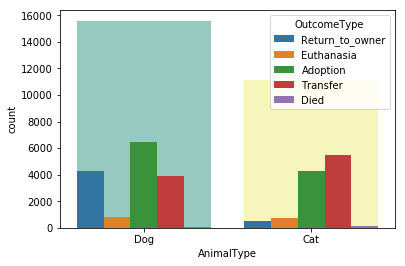

In [201]:
sns.countplot(data_train.AnimalType, palette='Set3')
sns.countplot(data=data_train, x='AnimalType',hue='OutcomeType')
plt.show()

#### 주인이 다시 찾아가는 비율은 개가 고양이에 비해서 압도적으로 높다.

### 4. SexuponOutcome

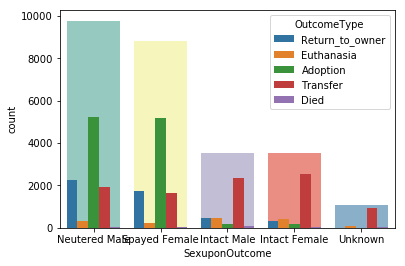

In [202]:
sns.countplot(data_train.SexuponOutcome, palette='Set3')
sns.countplot(data=data_train, x='SexuponOutcome',hue='OutcomeType')
plt.show()

#### 중성화 수술이 된 쪽이 자연상태인 쪽보다 주인이 찾아가는 비율과 입양되는 비율이 압도적으로 높았다. 
#### 자연상태의 개와 고양이는 이관되는 비율이 압도적으로 높다.

In [384]:
#SexuponOutcome은 그냥 Unknown
data_combined['SexuponOutcome'].fillna('Unknown', inplace = True)
data_combined['SexuponOutcome'].unique()

array(['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female',
       'Unknown'], dtype=object)

### 5. AgeuponOutcome

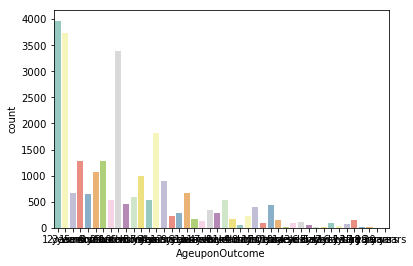

In [363]:
sns.countplot(data_train.AgeuponOutcome, palette='Set3')
plt.show()

### 너무 세분화 되어 있어서 보기 어렵다. 단순화작업 진행

In [364]:
def calc_age_in_years(x):
    x = str(x)
    if x == 'nan': return 0
    age = int(x.split()[0])
    if x.find('year') > -1: return age 
    if x.find('month')> -1: return age / 12.
    if x.find('week')> -1: return age / 52.
    if x.find('day')> -1: return age / 365.
    else: return 0

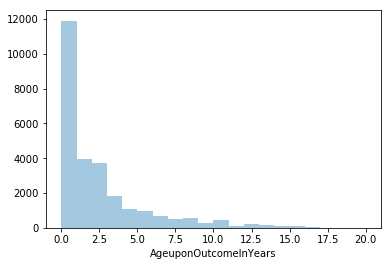

In [365]:

data_train1 = data_train.copy()
data_train1['AgeuponOutcomeInYears'] = data_train1.AgeuponOutcome.apply(calc_age_in_years)
sns.distplot(data_train1.AgeuponOutcomeInYears, bins = 20, kde=False)
plt.show()

In [366]:
def calc_age_category(x):
    if x < 3: return 'young'
    if x < 5: return 'young adult'
    if x < 10: return 'adult'
    return 'old'
data_train1['AgeCategory'] = data_train1.AgeuponOutcomeInYears.apply(calc_age_category)

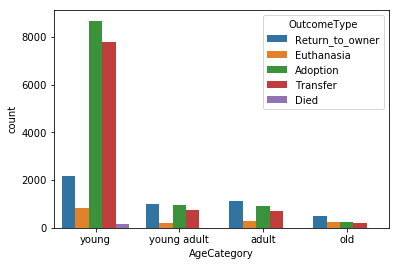

In [367]:
sns.countplot(data=data_train1, x='AgeCategory',hue='OutcomeType')
plt.show()

#### 3세 미만의 어린 개와 고양이가 입양 및 이관비율이 다른 연령대에 비해 압도적으로 높다. 
#### 10세 이상은 주인에게 돌아가는 비율이 다른 연령대에 비해 상대적으로 높다. 
* Modeling 시에는 one-hot-encoding 없이 바로 사용할 수 있도록 day를 기준으로 변환하여 사용

In [377]:
def convert_Age(data_train):
    '''Reference: https://stackoverflow.com/questions/12851791/removing-numbers-from-string'''
    '''This function convert all the time into unit of day'''
    age_list = list(data_train['AgeuponOutcome'])
    age_day_compile = []
    for item in age_list:
        if type(item) != str:
            age_day_compile.append(item)
        else:
            numeric = int(item[:2])
            if 'year' in item:
                age_day_compile.append(numeric * 365)
            elif 'month' in item:
                age_day_compile.append(numeric * 30)
            elif 'week' in item:
                age_day_compile.append(numeric * 7)
            elif 'day' in item:
                age_day_compile.append(numeric)
    return age_day_compile 

In [378]:
'''This section of the code is to check the unique string values that are present in the AgeuponOutcome column'''
age_list_compile = []
age_outcome_list = list(data_train['AgeuponOutcome'])
for item in age_outcome_list:
    if type(item) != str:
        '''This condition is to account for NaN values'''
        continue
    result = ''.join(i for i in item if not i.isdigit())
    age_list_compile.append(result)
'''We can check unique string values in the column'''
age_list_unique = list(pd.Series(age_list_compile).unique())
print(age_list_unique)
'''This list contains year(s), month(s), week(s), day(s)'''

[]


'This list contains year(s), month(s), week(s), day(s)'

In [379]:
age_day_compile = convert_Age(data_train)
data_train['AgeuponOutcome'] = age_day_compile

In [380]:
# age_list_unique 확인 결과 year, years, month, months, week, weeks, day, days의 유니크한 값을 가짐. 나이관련 변수 단위를 day로 통일

def convert_Age(data_combined):
    '''Reference: https://stackoverflow.com/questions/12851791/removing-numbers-from-string'''
    '''This function convert all the time into unit of day'''
    age_list = list(data_combined['AgeuponOutcome'])
    age_day_compile = []
    for item in age_list:
        if type(item) != str:
            age_day_compile.append(item)
        else:
            numeric = int(item[:2])
            if 'year' in item:
                age_day_compile.append(numeric * 365)
            elif 'month' in item:
                age_day_compile.append(numeric * 30)
            elif 'week' in item:
                age_day_compile.append(numeric * 7)
            elif 'day' in item:
                age_day_compile.append(numeric)
    return age_day_compile 

In [381]:
age_day_compile = convert_Age(data_combined)
data_combined['AgeuponOutcome'] = age_day_compile

In [382]:
data_combined.tail()

,AnimalID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason
11451,11452,No Name,2014-07-08 14:50,Cat,Neutered Male,60.0,Domestic Shorthair Mix,Black,201407,2014,07,08,14,summer
11452,11453,No Name,2014-10-21 12:57,Cat,Intact Female,14.0,Domestic Shorthair Mix,Blue,201410,2014,10,21,12,fall
11453,11454,No Name,2014-09-29 9:00,Cat,Intact Female,365.0,Domestic Shorthair Mix,Calico,201409,2014,09,29,9:,fall
11454,11455,Name,2015-09-05 17:16,Dog,Neutered Male,2190.0,German Shepherd Mix,Black/Tan,201509,2015,09,05,17,fall
11455,11456,Name,2014-07-12 18:40,Dog,Intact Male,1460.0,Labrador Retriever,Cream,201407,2014,07,12,18,summer


In [385]:
#AgeuponOutcome의 경우 전체 데이터의 median값으로 대체
age_median = data_combined['AgeuponOutcome'].median()
age_median

365.0

In [386]:
data_combined['AgeuponOutcome'].fillna(age_median, inplace = True)
data_combined['AgeuponOutcome'].isnull().sum()

0

### 6. Breed

In [212]:
# Breed 안에 있는 unique 갯수
data_train.Breed.nunique()

1380

In [213]:
# Breed 안에 있는 values
data_train['Breed'].value_counts()

Domestic Shorthair Mix                    8810
Pit Bull Mix                              1906
Chihuahua Shorthair Mix                   1766
Labrador Retriever Mix                    1363
Domestic Medium Hair Mix                   839
German Shepherd Mix                        575
Domestic Longhair Mix                      520
Siamese Mix                                389
Australian Cattle Dog Mix                  367
Dachshund Mix                              318
Boxer Mix                                  245
Miniature Poodle Mix                       233
Border Collie Mix                          229
Australian Shepherd Mix                    163
Rat Terrier Mix                            157
Catahoula Mix                              157
Jack Russell Terrier Mix                   146
Domestic Shorthair                         143
Yorkshire Terrier Mix                      143
Chihuahua Longhair Mix                     142
                                          ... 
Flat Coat Ret

In [214]:
## 개 순종/잡종 분류

def dog_breed_category(data_train):
    '''This function converts the breed into pure mix, mix or pure'''
    breed_df = data_train[['OutcomeType', 'AnimalType', 'Breed']]
    breed_df_dog = breed_df[breed_df.AnimalType == 'Dog'].reset_index()
    breed_list = list(breed_df_dog['Breed'])
    breed_compile = []
    for item in breed_list:
        item = item.lower()
        if 'mix' in item:
            breed_compile.append('pure mix')
        elif '/' in item:
            breed_compile.append('mix')
        else:
            breed_compile.append('pure')
    breed_df_dog['Breed_dog'] = breed_compile
    return breed_df_dog

In [215]:
breed_df_dog = dog_breed_category(data_train)

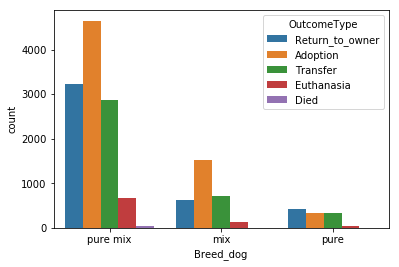

In [216]:
#순종/잡종 개와 OutcomeType 관계 그래프
sns.countplot(x = 'Breed_dog', hue = 'OutcomeType', data = breed_df_dog)
plt.show()

#### 순종견 (Pure)는 갯수가 많지 않기 때문에 Pure mix와 Pure는 같은 종으로 고려함 (타 Kaggle 분석에서도 이런식으로 진행한것 확인)

### Breed의 Unique값 분석결과 1200종이 넘는것으로 확인됨. 이러한 data를 그래로 사용할 경우 Overfitting등의 문제가 있기 때문에 3가지 방법으로 접근할 예정
  
1) 순종 Breed에 관해서는 Size로 변환 -> 잡종일 경우 유전적 factor에 의해서 크기 예측이 쉽지 않음. 이 작업을 수작업으로 하기에는 너무 많은 시간이 소요가 되기 때문에 방법 탐색중 순종을 크기 별로 나눠놓은 웹사이트 발견 -> Crawling

Mixed Breed Reference: http://www.vetstreet.com/our-pet-experts/can-you-predict-the-adult-size-of-a-mixed-breed-puppy

Size Reference : http://www.dogbreedslist.info/herding-dog-breeds/#.WgfCyMZl-iN

2) 또다른 방법은 Breed를 Main breed와 Sub breed열로 나눠서 분석

3) 애완견의 선호도 랭킹 반영 : 다른 Kaggle 참가자에 따르면 애완견의 선호도 랭킹또한 예측 모델에 큰 영향을 준다는 정보 입수

Ranking Reference: https://nishadikirielle.wordpress.com/2016/10/08/kaggle-competition-shelter-animal-problem-xgboost-approach/

개는 2016년 기준으로 랭킹이 매겨져 있으며 고양이는 2014년 기준으로 랭킹이 존재함. 위 첨부자료에서는 2013, 2014, 2015년별 랭킹변화를 모두 인자로 채택했지만, 자세히 보면 랭킹에 큰 변동이 없는것으로 확인되었기 때문에 굳이 매년 선호도 점수를 쓸 필요성은 없는것으로 판단됨.

#### 1) Size별로 정리

In [357]:
# Size별 정보 Crawling by BeautifulSoup
def crawler(url, selector):
    '''This is one of the two functions used for crawlign cat/dog size'''
    res = requests.get(url)
    soup = BeautifulSoup(res.content, 'html.parser')
    crawl_list = soup.select(selector)
    compile_list = []
    for breed in crawl_list:
        compile_list.append(breed.get_text().lower())
    return compile_list

def crawl_compiler(url_list, selector):
    '''This is the second functions used for crawlign cat/dog size'''
    list_compile = []
    for url in url_list:
        crawler_list = crawler(url, selector)
        list_compile += crawler_list
    return list_compile


In [358]:
'''This section is for crawling the dog size list'''

'''Extract list of dogs for different sizes'''
small_url_list = ['http://www.dogbreedslist.info/small-dog-breeds/list_2_1.html#.Wfx1Mmi0NPY', 
                'http://www.dogbreedslist.info/small-dog-breeds/list_2_2.html#.Wfx1Mmi0NPY', 
                'http://www.dogbreedslist.info/small-dog-breeds/list_2_3.html#.Wfx1Mmi0NPY', 
                'http://www.dogbreedslist.info/small-dog-breeds/list_2_4.html#.Wfx1Mmi0NPY', 
                'http://www.dogbreedslist.info/small-dog-breeds/list_2_5.html#.Wfx1Mmi0NPY',
                'http://www.dogbreedslist.info/small-dog-breeds/list_2_6.html#.Wfx1Mmi0NPY']

selector = 'body > div.main > div.main-r > div > div.list-01 > div.right > div.right-t > p > a'
small_dog_compile = crawl_compiler(small_url_list, selector)

medium_url_list = ['http://www.dogbreedslist.info/medium-dog-breeds/list_3_1.html#.Wfx3bmi0NPY',
                   'http://www.dogbreedslist.info/medium-dog-breeds/list_3_2.html#.Wfx3bmi0NPY',
                   'http://www.dogbreedslist.info/medium-dog-breeds/list_3_3.html#.Wfx3bmi0NPY', 
                   'http://www.dogbreedslist.info/medium-dog-breeds/list_3_4.html#.Wfx3bmi0NPY',
                   'http://www.dogbreedslist.info/medium-dog-breeds/list_3_5.html#.Wfx3bmi0NPY',
                   'http://www.dogbreedslist.info/medium-dog-breeds/list_3_6.html#.Wfx3bmi0NPY']

selector = 'body > div.main > div.main-r > div > div.list-01 > div.right > div.right-t > p > a'
medium_dog_compile = crawl_compiler(medium_url_list, selector) + ['treeing cur', 'treeing tennesse brindle']

large_url_list = ['http://www.dogbreedslist.info/large-dog-breeds/list_4_1.html#.Wfx9nWi0NPY',
                   'http://www.dogbreedslist.info/large-dog-breeds/list_4_2.html#.Wfx9nWi0NPY',
                   'http://www.dogbreedslist.info/large-dog-breeds/list_4_3.html#.Wfx9nWi0NPY', 
                   'http://www.dogbreedslist.info/large-dog-breeds/list_4_4.html#.Wfx9nWi0NPY',
                   'http://www.dogbreedslist.info/large-dog-breeds/list_4_5.html#.Wfx9nWi0NPY',
                   'http://www.dogbreedslist.info/large-dog-breeds/list_4_6.html#.Wfx9nWi0NPY']

selector = 'body > div.main > div.main-r > div > div.list-01 > div.right > div.right-t > p > a'
large_dog_compile = crawl_compiler(large_url_list, selector) + ['schnauzer giant', 'olde english bulldogge']

giant_url_list = ['http://www.dogbreedslist.info/giant-dog-breeds/list_5_1.html#.Wfx9nWi0NPY',]

selector = 'body > div.main > div.main-r > div > div.list-01 > div.right > div.right-t > p > a'
giant_dog_compile = crawl_compiler(giant_url_list, selector)

In [359]:
print(medium_dog_compile)

['labrador retriever', 'bulldog', 'poodle', 'boxer', 'siberian husky', 'australian shepherd', 'brittany', 'english springer spaniel', 'american cocker spaniel', 'vizsla', 'weimaraner', 'miniature american shepherd', 'border collie', 'basset hound', 'shiba inu', 'belgian malinois', 'soft coated wheaten terrier', 'portuguese water dog', 'australian cattle dog', 'airedale terrier', 'english cocker spaniel', 'bull terrier', 'whippet', 'shar-pei', 'german wirehaired pointer', 'samoyed', 'wirehaired pointing griffon', 'chow chow', 'american staffordshire terrier', 'staffordshire bull terrier', 'standard schnauzer', 'nova scotia duck tolling retriever', 'basenji', 'tibetan terrier', 'norwegian elkhound', 'wire fox terrier', 'belgian tervuren', 'boykin spaniel', 'lagotto romagnolo', 'pointer', 'american eskimo dog', 'welsh springer spaniel', 'bearded collie', 'kerry blue terrier', 'treeing walker coonhound', 'berger picard', 'redbone coonhound', 'clumber spaniel', 'german pinscher', 'field spa

In [387]:
# 순종 Mix 와 순종을 같은 Breed로 설정

def remove_mix(data_train):
    '''This function removes the keyword mix from breed list. The result from
    this method is used when converting breed into different categories'''
    breed_list = list(data_train['Breed'])
    breed_compile = []
    for item in breed_list:
        item = item.lower()
        if 'mix' in item:
            item = item[:-4]
        breed_compile.append(item)
    return breed_compile


In [388]:
breed_remove_mix = remove_mix(data_train)

In [389]:
# 순종 Mix 와 순종을 같은 Breed로 설정

def remove_mix(data_combined):
    '''This function removes the keyword mix from breed list. The result from
    this method is used when converting breed into different categories'''
    breed_list = list(data_combined['Breed'])
    breed_compile = []
    for item in breed_list:
        item = item.lower()
        if 'mix' in item:
            item = item[:-4]
        breed_compile.append(item)
    return breed_compile

In [390]:
breed_remove_mix = remove_mix(data_combined)

In [391]:
# train.csv에 있는 모든 견종이 Crawling한 list에 존재하거나 줄임말 또는 표기법이 달라서 인식이 안되는 종이 30종 정도 있는 것으로 확인됨.
# 그 수가 그렇게 많지 않기 때문에 직접 수정함.

for index, item in enumerate(breed_remove_mix):
    if item == 'chihuahua shorthair':
        breed_remove_mix[index] = 'chihuahua'
    elif item == 'collie smooth':
        breed_remove_mix[index] = 'collie'
    elif item == 'anatol shepherd':
        breed_remove_mix[index] = 'anatolian shepherd dog'
    elif item == 'port water dog':
        breed_remove_mix[index] = 'portuguese water dog'
    elif item == 'flat coat retriever':
        breed_remove_mix[index] = 'flat-coated retriever'
    elif item == 'pbgv':
        breed_remove_mix[index] = 'petit basset griffon vendeen'
    elif item == 'bruss griffon':
        breed_remove_mix[index] = 'brussels griffon'
    elif item == 'bluetick hound':
        breed_remove_mix[index] = 'bluetick coonhound'
    elif item == 'wire hair fox terrier':
        breed_remove_mix[index] = 'wire fox terrier'
    elif item == 'dachshund wirehair':
        breed_remove_mix[index] = 'dachshund'
    elif item == 'rhod ridgeback':
        breed_remove_mix[index] = 'rhodesian ridgeback'
    elif item == 'picardy sheepdog':
        breed_remove_mix[index] = 'berger picard'
    elif item == 'st. bernard rough coat':
        breed_remove_mix[index] = 'st. bernard'
    elif item == 'old english bulldog':
        breed_remove_mix[index] = 'olde english bulldogge'
    elif item == 'english bulldog':
        breed_remove_mix[index] = 'olde english bulldogge'
    elif item == 'chesa bay retr':
        breed_remove_mix[index] = 'chesapeake bay retriever'
    elif item == 'dachshund longhair':
        breed_remove_mix[index] = 'dachshund'
    elif item == 'chihuahua longhair':
        breed_remove_mix[index] = 'chihuahua'
    elif item == 'chinese sharpei':
        breed_remove_mix[index] = 'shar-pei'
    elif item == 'standard poodle':
        breed_remove_mix[index] = 'poodle'
    elif item == 'bull terrier miniature':
        breed_remove_mix[index] = 'miniature bull terrier'
    elif item =='st. bernard smooth coat':
        breed_remove_mix[index] = 'st. bernard'
    elif item =='redbone hound':
        breed_remove_mix[index] = 'redbone coonhound'
    elif item == 'cavalier span':
        breed_remove_mix[index] = 'cavalier king charles spaniel'
    elif item == 'collie rough':
        breed_remove_mix[index] = 'collie'
    elif item == 'german shorthair pointer':
        breed_remove_mix[index] = 'german shorthaired pointer'
    elif item == 'english pointer':
        breed_remove_mix[index] = 'pointer'
    elif item == 'mexican hairless':
        breed_remove_mix[index] = 'xoloitzcuintli'
    elif item =='dogo argentino':
        breed_remove_mix[index] = 'argentine dogo'
    elif item == 'queensland heeler':
        breed_remove_mix[index] = 'australian cattle dog'

In [400]:
# 고양이 사이즈 : 고양이는 종류가 강아지만큼 다양하지 않기 때문에 수작업 전처리 진행

# Reference: http://www.petguide.com/breeds/cat/domestic-longhair/

small_cat_list = ['munchkin longhair', 'oriental sh']
medium_cat_list = ['exotic shorthair', 'persian', 'abyssinian', 'sphynx', 'siamese',
                   'cornish rex', 'devon rex', 'burmese', 'tonkinese', 'russian blue', 
                   'manx', 'japanese bobtail', 'balinese', 'bombay', 'havana brown',
                   'bengal', 'cymric', 'himalayan', 'snowshoe', 'javanese', 'havana brown', 'angora', 'turkish angora', 
                   'munchkin shorthair', 'scottish fold']
large_cat_list = ['american shorthair', 'british shorthair', 'norwegian forest cat', 'ocicat',
                  'turkish van', 'pixiebob shorthair', 'maine coon', 'ragdoll', 'american wirehair', 'chartreux']
domestic = ['domestic longhair', 'domestic medium hair', 'domestic shorthair']

고양이종에 domestic이 붙은 종은 북미지역에 서식하는 잡종 고양이를 뜻함. train 데이터에서도 압도적으로 많은 고양이들이 domestic 종이고 실제로도 북미지역 애완 고양이는 높은 비율로 domestic 잡종인것을 아래 참조 자료를 통해 확인하였음. 잡종인 만큼 size를 예측하기 힘들기 때문에 domestic이라는 카테고리를 따로 형성함

#### Reference: http://www.petguide.com/breeds/cat/domestic-longhair/

In [393]:
# mapping : 개는 1, 고양이는 0 으로 전처리

animal_type_mapping = {'Dog':1, 'Cat':0}
data_train['AnimalType'] = data_train['AnimalType'].map(animal_type_mapping)

In [396]:
animal_type_mapping = {'Dog':1, 'Cat':0}
data_combined['AnimalType'] = data_combined['AnimalType'].map(animal_type_mapping)

In [403]:
# 개/고양이 Size 인자 형성

# Reference: https://stackoverflow.com/questions/16380326/check-if-substring-is-in-a-list-of-strings

def convert_breed(type_list, breed_list, small_list, medium_list, large_list, giant_list,
                  small_cat_list, medium_cat_list, large_cat_list, domestic_cat_list):
    '''Reference: https://stackoverflow.com/questions/16380326/check-if-substring-is-in-a-list-of-strings
    that is a really smart and succinct solution for checking substring existence in a list of strings'''
    
    '''The incoming list a list of breeds with the keyword "mix" removed and converted
    to lower case. No need for extra preprocessing. Also the dog lists are all converted
    to lower case as well. Type list is to check whether the breed belongs to dog or cat'''
    if len(type_list) != len(breed_list):
        print('Two lists must have equal length!')
        return None
    
    '''Convert the list into a string format for easier processing'''
    small_combined = '\t'.join(small_list)
    medium_combined = '\t'.join(medium_list)
    large_combined = '\t'.join(large_list)
    giant_combined = '\t'.join(giant_list)
    
    breed_compile, excluded_list, mix_breed_list, cat_breed_list = [], [], [], []
    for animal_type, breed in zip(type_list, breed_list):
        if '/' in breed: #Mixed type categorization
            mix_breed_list.append(breed)
            breed_compile.append('mix')
        elif animal_type == 0: #Cat breed categorization
            cat_breed_list.append(breed)
            if breed in small_cat_list:
                breed_compile.append('small_cat')
            elif breed in medium_cat_list:
                breed_compile.append('medium_cat')
            elif breed in large_cat_list:
                breed_compile.append('large_cat')
            elif breed in domestic_cat_list:
                breed_compile.append('domestic')
            else:
                excluded_list.append(breed)
        elif animal_type == 1: #Dog breed categorization
            if breed in small_combined:
                breed_compile.append('small')
            elif breed in medium_combined:
                breed_compile.append('medium')
            elif breed in large_combined:
                breed_compile.append('large')
            elif breed in giant_combined:
                breed_compile.append('giant')
            else:
                excluded_list.append(breed)
                breed_compile.append('unknown')
    return breed_compile, excluded_list, mix_breed_list, cat_breed_list

In [404]:
'''Compare the breed in the data to crawled size lists and create a list indicating
the size of each breed. By zipping two lists, we can also ignore species that
belong to cats. Some breed names were manually modified to fit the crawled list'''
type_list = list(data_combined['AnimalType'])

convert_list, excluded_list_dog, mix_breed_list_dog, cat_breed_list = convert_breed(type_list, 
                                     breed_remove_mix, small_dog_compile, 
                                     medium_dog_compile, large_dog_compile, giant_dog_compile,
                                     small_cat_list, medium_cat_list, large_cat_list, domestic)

'''With the manual correction to dog breed, this list should only contain unknown values'''
excluded_unique_dog = list(set(excluded_list_dog))
print(excluded_unique_dog)

['unknown', 'eng toy spaniel', 'dachshund stan']


In [405]:
'''Whew finally add the cleansed convert_dog_list to our data_train DataFrame'''
data_combined['Size'] = convert_list
data_combined.tail()

,AnimalID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason,Size
11451,11452,No Name,2014-07-08 14:50,0,Neutered Male,60.0,Domestic Shorthair Mix,Black,201407,2014,07,08,14,summer,domestic
11452,11453,No Name,2014-10-21 12:57,0,Intact Female,14.0,Domestic Shorthair Mix,Blue,201410,2014,10,21,12,fall,domestic
11453,11454,No Name,2014-09-29 9:00,0,Intact Female,365.0,Domestic Shorthair Mix,Calico,201409,2014,09,29,9:,fall,domestic
11454,11455,Name,2015-09-05 17:16,1,Neutered Male,2190.0,German Shepherd Mix,Black/Tan,201509,2015,09,05,17,fall,large
11455,11456,Name,2014-07-12 18:40,1,Intact Male,1460.0,Labrador Retriever,Cream,201407,2014,07,12,18,summer,medium


In [406]:
'''Confirm that only expected values small, medium, large, giant, unknown and domestic
are present in the Size column'''
size_check_list = list(data_combined['Size'].unique())
print(size_check_list)

['small', 'domestic', 'medium', 'mix', 'giant', 'medium_cat', 'large', 'large_cat', 'unknown', 'small_cat']


#### 고양이 경우 앞서 말했듯이 domestic종이 다른 종에 비해 압도적으로 많은 것으로 확인됨. 따라서 차후 머신러닝 알고리즘 적용시 고양이와 개의 분류는 AnimalType에 의해서 이루어 질지 아니면 domestic이라는 종에 의해서 이루어 질지 확인해볼 필요가 있음

#### 완변하진 않지만 각각 결과값에 따른 애완견 사이즈별 비율이 비슷한 형태를 하고 있는것으로 판단됨. 어쩌면 size가 생각보다 중요하지 않은 인자일수도? 

#### 2) Main/Sub 로 분리

In [407]:
# 종이 3개 이상 섞여 있는 경우의 갯수
check_breed = list(data_train['Breed'])
count = 0
for item in check_breed:
    if item.count('/') == 2:
        count += 1
print(count)

10


#### 10개밖에 없기때문에 잡종일 경우 main과 sub로만 분리 (원래 계획은 sub1, sub2로 나눌 계획이었음)

In [408]:
def main_sub_separator(separate_list):
    '''This function separates the breed into main and sub breed columns'''
    main, sub = [], []
    for item in separate_list:
        if item.count('/') == 0:
            main.append(item)
            sub.append('NA')
        elif item.count('/') == 1 or item.count('/') == 2:
            temp_list = item.split('/')
            main.append(temp_list[0])
            sub.append(temp_list[1])
    return main, sub

In [409]:
#Animal Breed Separator
main_breed, sub_breed = main_sub_separator(breed_remove_mix)
data_combined['Main_Breed'], data_combined['Sub_Breed'] = main_breed, sub_breed

#### 3) 애완견 선호도 랭킹 반영

#### Reference: https://nishadikirielle.wordpress.com/2016/10/08/kaggle-competition-shelter-animal-problem-xgboost-approach/

Size, 선호도 랭킹 웹사이트에 의하면 개는 2016년 선호도 랭킹 고양이는 2014년 선호도 랭킹 정보가 있다. 각각의 인자를 rank_dog와 rank_cat으로 구분하여서 형성. rank_dog일 경우 고양이거나 랭킹이 없을경우 0으로 설정, rank_cat의 경우 개이거나 랭킹이 없을경우 마찬가지로 0으로 설정.

실제 들어갈 데이터는 랭킹이 아니라 maximum_ranking - actual_ranking이라는 인자로 넣을 계획. 이렇게 될 경우 높은 랭킹을 가진 종은 점수가 높을 것이고 낮은 랭킹을 가질경우 당연히 낮은 점수를 가지고 가게 될것이다.

데이터 형성은 위쪽 Crawling에서 작성한 rank_dict_dog와 rank_dict_cat와 data_combined의 Main_Breed column을 이용한다.

In [360]:
'''This portion is for crawling the favorite ranking of dogs'''

ranking_url_list = []
for i in range(1, 11):
    url = 'http://www.dogbreedslist.info/all-dog-breeds/list_1_' + str(i) + '.html#.WhE_9kpl-iM'
    ranking_url_list.append(url)
    
selector_breed = 'body > div.main > div.main-r > div > div.list-01 > div.right > div.right-t > p > a'
selector_rank = 'body > div.main > div.main-r > div > div.list-02 > p'

breed_compile_dog = crawl_compiler(ranking_url_list, selector_breed)
rank_compile_dog = crawl_compiler(ranking_url_list, selector_rank)

In [361]:
breed_compile_dog = breed_compile_dog[:188]
rank_compile_dog = rank_compile_dog[:188]

In [362]:
print(len(breed_compile_dog))
print(breed_compile_dog)

188
['labrador retriever', 'german shepherd', 'golden retriever', 'bulldog', 'beagle', 'french bulldog', 'poodle', 'rottweiler', 'yorkshire terrier', 'boxer', 'german shorthaired pointer', 'siberian husky', 'dachshund', 'great dane', 'doberman pinscher', 'australian shepherd', 'miniature schnauzer', 'pembroke welsh corgi', 'cavalier king charles spaniel', 'shih tzu', 'boston terrier', 'pomeranian', 'havanese', 'shetland sheepdog', 'brittany', 'english springer spaniel', 'bernese mountain dog', 'mastiff', 'american cocker spaniel', 'chihuahua', 'vizsla', 'pug', 'maltese', 'weimaraner', 'newfoundland', 'miniature american shepherd', 'collie', 'border collie', 'basset hound', 'cane corso', 'west highland white terrier', 'rhodesian ridgeback', 'chesapeake bay retriever', 'shiba inu', 'bichon frise', 'akita', 'belgian malinois', 'bullmastiff', 'st. bernard', 'soft coated wheaten terrier', 'portuguese water dog', 'bloodhound', 'papillon', 'australian cattle dog', 'airedale terrier', 'english

In [238]:
print(len(rank_compile_dog))
print(rank_compile_dog)

188
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '63', '64', '65', '66', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158

In [239]:
rank_compile_dog_numeric = []
for item in rank_compile_dog:
    rank_compile_dog_numeric.append(int(item))
rank_compile_dog_numeric

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 63,
 64,
 65,
 66,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 186

In [240]:
rank_dict_dog = {}
for breed, rank in zip(breed_compile_dog, rank_compile_dog_numeric):
    rank_dict_dog[breed] = rank
print(rank_dict_dog)

{'west highland white terrier': 41, 'curly-coated retriever': 164, 'treeing walker coonhound': 137, 'canaan dog': 181, 'brittany': 25, 'norwich terrier': 103, 'chinese crested': 77, 'kerry blue terrier': 127, 'finnish lapphund': 173, 'belgian sheepdog': 129, 'weimaraner': 34, 'bulldog': 4, 'norfolk terrier': 134, 'american foxhound': 189, 'wirehaired pointing griffon': 66, 'border terrier': 86, 'lowchen': 171, 'tibetan spaniel': 118, 'american hairless terrier': 106, 'sussex spaniel': 172, 'old english sheepdog': 75, 'norwegian elkhound': 94, 'whippet': 60, 'dachshund': 13, 'border collie': 38, 'rottweiler': 8, 'havanese': 23, 'siberian husky': 12, 'spanish water dog': 162, 'afghan hound': 113, 'german shorthaired pointer': 11, 'rat terrier': 96, 'giant schnauzer': 79, 'saluki': 125, 'bouvier des flandres': 83, 'boerboel': 131, 'coton de tulear': 80, 'german wirehaired pointer': 64, 'finnish spitz': 179, 'tibetan mastiff': 135, 'australian terrier': 136, 'japanese chin': 108, 'cairn te

In [412]:
data_combined['Size'].value_counts()

domestic      14845
medium         8846
small          6765
mix            4357
large          2059
medium_cat      928
giant           257
large_cat       122
unknown           4
small_cat         2
Name: Size, dtype: int64

In [413]:
#1 for dog and 0 for cat
data_combined['AnimalType'].value_counts()

1    22251
0    15934
Name: AnimalType, dtype: int64

#### 고양이의 경우 전체 (train.csv + test.csv) 15934데이터중 14845개가 domestic type인것으로 확인되었다. 고양이는 굳이 선호도 랭킹을 적용할 필요없고 강아지 랭킹 column에 고양이일 경우도 그냥 0값으로 대체하는것이 좋을것을 판단됨.

In [415]:
temp = data_combined['Main_Breed']
temp

0                shetland sheepdog
1               domestic shorthair
2                         pit bull
3               domestic shorthair
4                       lhasa apso
5                    cairn terrier
6               domestic shorthair
7               domestic shorthair
8        american pit bull terrier
9                    cairn terrier
10              domestic shorthair
11             miniature schnauzer
12                        pit bull
13               yorkshire terrier
14                  great pyrenees
15              domestic shorthair
16              domestic shorthair
17                        pit bull
18                          angora
19           flat-coated retriever
                   ...            
11436           domestic shorthair
11437           chihuahua longhair
11438           labrador retriever
11439                     pit bull
11440           domestic shorthair
11441                     pit bull
11442                    chihuahua
11443            dom

In [416]:
temp2 = temp.map(rank_dict_dog)
temp2

0         24.0
1          NaN
2          NaN
3          NaN
4         71.0
5         70.0
6          NaN
7          NaN
8          NaN
9         70.0
10         NaN
11        17.0
12         NaN
13         9.0
14        67.0
15         NaN
16         NaN
17         NaN
18         NaN
19        89.0
         ...  
11436      NaN
11437      NaN
11438      1.0
11439      NaN
11440      NaN
11441      NaN
11442     30.0
11443      NaN
11444      NaN
11445      NaN
11446      NaN
11447     30.0
11448      1.0
11449    126.0
11450      NaN
11451      NaN
11452      NaN
11453      NaN
11454      2.0
11455      1.0
Name: Main_Breed, Length: 38185, dtype: float64

In [417]:
temp2 = 190 - temp2
temp2

0        166.0
1          NaN
2          NaN
3          NaN
4        119.0
5        120.0
6          NaN
7          NaN
8          NaN
9        120.0
10         NaN
11       173.0
12         NaN
13       181.0
14       123.0
15         NaN
16         NaN
17         NaN
18         NaN
19       101.0
         ...  
11436      NaN
11437      NaN
11438    189.0
11439      NaN
11440      NaN
11441      NaN
11442    160.0
11443      NaN
11444      NaN
11445      NaN
11446      NaN
11447    160.0
11448    189.0
11449     64.0
11450      NaN
11451      NaN
11452      NaN
11453      NaN
11454    188.0
11455    189.0
Name: Main_Breed, Length: 38185, dtype: float64

In [418]:
temp2.fillna(0, inplace = True)
temp2

0        166.0
1          0.0
2          0.0
3          0.0
4        119.0
5        120.0
6          0.0
7          0.0
8          0.0
9        120.0
10         0.0
11       173.0
12         0.0
13       181.0
14       123.0
15         0.0
16         0.0
17         0.0
18         0.0
19       101.0
         ...  
11436      0.0
11437      0.0
11438    189.0
11439      0.0
11440      0.0
11441      0.0
11442    160.0
11443      0.0
11444      0.0
11445      0.0
11446      0.0
11447    160.0
11448    189.0
11449     64.0
11450      0.0
11451      0.0
11452      0.0
11453      0.0
11454    188.0
11455    189.0
Name: Main_Breed, Length: 38185, dtype: float64

In [419]:
print(type(temp2))
print(temp2.shape)

<class 'pandas.core.series.Series'>
(38185,)


In [421]:
data_combined['Rank'] = temp2

In [423]:
#Data display
data_combined.tail()

,AnimalID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason,Size,Main_Breed,Sub_Breed,Main_Color,Sub_Color,Rank
11451,11452,No Name,2014-07-08 14:50,0,Neutered Male,60.0,Domestic Shorthair Mix,Black,201407,2014,07,08,14,summer,domestic,domestic shorthair,NA,Black,NA,0.0
11452,11453,No Name,2014-10-21 12:57,0,Intact Female,14.0,Domestic Shorthair Mix,Blue,201410,2014,10,21,12,fall,domestic,domestic shorthair,NA,Blue,NA,0.0
11453,11454,No Name,2014-09-29 9:00,0,Intact Female,365.0,Domestic Shorthair Mix,Calico,201409,2014,09,29,9:,fall,domestic,domestic shorthair,NA,Calico,NA,0.0
11454,11455,Name,2015-09-05 17:16,1,Neutered Male,2190.0,German Shepherd Mix,Black/Tan,201509,2015,09,05,17,fall,large,german shepherd,NA,Black,Tan,188.0
11455,11456,Name,2014-07-12 18:40,1,Intact Male,1460.0,Labrador Retriever,Cream,201407,2014,07,12,18,summer,medium,labrador retriever,NA,Cream,NA,189.0


In [424]:
data_combined.shape

(38185, 20)

### 7. Color

In [410]:
#Color Separator
color_list = list(data_combined['Color'])
main_color, sub_color = main_sub_separator(color_list)
data_combined['Main_Color'], data_combined['Sub_Color'] = main_color, sub_color

In [411]:
data_combined.tail()

,AnimalID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason,Size,Main_Breed,Sub_Breed,Main_Color,Sub_Color
11451,11452,No Name,2014-07-08 14:50,0,Neutered Male,60.0,Domestic Shorthair Mix,Black,201407,2014,07,08,14,summer,domestic,domestic shorthair,NA,Black,NA
11452,11453,No Name,2014-10-21 12:57,0,Intact Female,14.0,Domestic Shorthair Mix,Blue,201410,2014,10,21,12,fall,domestic,domestic shorthair,NA,Blue,NA
11453,11454,No Name,2014-09-29 9:00,0,Intact Female,365.0,Domestic Shorthair Mix,Calico,201409,2014,09,29,9:,fall,domestic,domestic shorthair,NA,Calico,NA
11454,11455,Name,2015-09-05 17:16,1,Neutered Male,2190.0,German Shepherd Mix,Black/Tan,201509,2015,09,05,17,fall,large,german shepherd,NA,Black,Tan
11455,11456,Name,2014-07-12 18:40,1,Intact Male,1460.0,Labrador Retriever,Cream,201407,2014,07,12,18,summer,medium,labrador retriever,NA,Cream,NA


In [256]:
data_train.isnull().sum()

AnimalID              0
Name                  0
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
Date                  0
OutcomeYear           0
OutcomeMonth          0
OutcomeDay            0
OutcomeHour           0
OutcomeSeason         0
Main_Breed            0
Sub_Breed             0
Rank                  0
Main_Color            0
Sub_Color             0
dtype: int64

### One-Hot-Encoding

In [425]:
# get_dummies 를 이용한 One-Hot-Encoding

main_color_gd = pd.get_dummies(data_combined[['Main_Color']])
sub_color_gd = pd.get_dummies(data_combined[['Sub_Color']])
main_breed_gd = pd.get_dummies(data_combined[['Main_Breed']])
sub_breed_gd = pd.get_dummies(data_combined[['Sub_Breed']])
year_gd = pd.get_dummies(data_combined[['OutcomeYear']])
month_gd = pd.get_dummies(data_combined[['OutcomeMonth']])
day_gd = pd.get_dummies(data_combined[['OutcomeDay']])
hour_gd = pd.get_dummies(data_combined[['OutcomeHour']])
size_gd = pd.get_dummies(data_combined['Size'])
sex_gd = pd.get_dummies(data_combined['SexuponOutcome'])
season_gd = pd.get_dummies(data_combined[['OutcomeSeason']])

In [428]:
year_gd.head()

,OutcomeYear_2013,OutcomeYear_2014,OutcomeYear_2015,OutcomeYear_2016
0,0,1,0,0
1,1,0,0,0
2,0,0,1,0
3,0,1,0,0
4,1,0,0,0


In [429]:
sex_gd.head()

,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown
0,0,0,1,0,0
1,0,0,0,1,0
2,0,0,1,0,0
3,0,1,0,0,0
4,0,0,1,0,0


In [430]:
size_gd.tail()

,domestic,giant,large,large_cat,medium,medium_cat,mix,small,small_cat,unknown
11451,1,0,0,0,0,0,0,0,0,0
11452,1,0,0,0,0,0,0,0,0,0
11453,1,0,0,0,0,0,0,0,0,0
11454,0,0,1,0,0,0,0,0,0,0
11455,0,0,0,0,1,0,0,0,0,0


In [399]:
# Outcome_mapping
outcome_mapping = {'Adoption':1, 'Died':2, 'Euthanasia':3, 'Return_to_owner':4, 'Transfer':5}
dfY = dfY.map(outcome_mapping)
print(dfY)

0        4
1        3
2        1
3        5
4        5
5        5
6        5
7        5
8        1
9        1
10       5
11       1
12       1
13       4
14       4
15       1
16       5
17       5
18       5
19       4
        ..
26709    1
26710    5
26711    5
26712    4
26713    3
26714    1
26715    1
26716    1
26717    4
26718    1
26719    5
26720    1
26721    1
26722    5
26723    1
26724    5
26725    5
26726    1
26727    5
26728    5
Name: OutcomeType, Length: 26729, dtype: int64


In [432]:
data_combined.drop('DateTime', axis = 1, inplace = True)

In [433]:
#Name
def no_name_numeric_label(x):
    '''Reference: https://github.com/JihongL/Shelter-Animal-Outcomes/blob/master/Shelter_EDA.ipynb'''
    '''This function is used in conjunction with .transform() method to convert Name and No Name 
    to numerical values'''
    if x == 'No Name':
        return 0
    else:
        return 1

data_train['Name'] = data_train['Name'].transform(no_name_numeric_label)
data_combined['Name'] = data_combined['Name'].transform(no_name_numeric_label)

In [434]:
data_combined.tail()

,AnimalID,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason,Size,Main_Breed,Sub_Breed,Main_Color,Sub_Color,Rank
11451,11452,0,0,Neutered Male,60.0,Domestic Shorthair Mix,Black,201407,2014,07,08,14,summer,domestic,domestic shorthair,NA,Black,NA,0.0
11452,11453,0,0,Intact Female,14.0,Domestic Shorthair Mix,Blue,201410,2014,10,21,12,fall,domestic,domestic shorthair,NA,Blue,NA,0.0
11453,11454,0,0,Intact Female,365.0,Domestic Shorthair Mix,Calico,201409,2014,09,29,9:,fall,domestic,domestic shorthair,NA,Calico,NA,0.0
11454,11455,1,1,Neutered Male,2190.0,German Shepherd Mix,Black/Tan,201509,2015,09,05,17,fall,large,german shepherd,NA,Black,Tan,188.0
11455,11456,1,1,Intact Male,1460.0,Labrador Retriever,Cream,201407,2014,07,12,18,summer,medium,labrador retriever,NA,Cream,NA,189.0


### train, test 데이터 분리

get_dummies적용등 여러면에서 train.csv과 test.csv 데이터를 합쳐서 전처리 하는것이 더 수월하다고 판단되어서 진행하였음. 모델 최적화를 위해서 두 데이터를 나누는 작업을 진행.

차후 용어가 헤깔릴수도 있기 때문에 정리하자면

1) train.csv 또는 Kaggle training 데이터, test.csv 또는 Kaggle test 데이터는 각각 Kaggle Competition에서 제공해준 train, test데이터를 지칭한다

2) 뒷쪽 모델 최적화에서 그냥 train 데이터 또는 test데이터는 train.csv에서 모델 검증을 위해 train_test_split을 통해 형성된 데이터를 지칭한다

In [435]:
data_train_final = data_combined.iloc[:26729, :]
data_test_final = data_combined.iloc[26729:, :]

In [436]:
#Train과 Test데이터 행 갯수는 각각 처음에 train.csv와 test.csv의 행 갯수와 동일해야 한다
print(data_train_final.shape, data_test_final.shape)

(26729, 19) (11456, 19)


In [437]:
data_train_final.tail()

,AnimalID,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason,Size,Main_Breed,Sub_Breed,Main_Color,Sub_Color,Rank
26724,A702446,0,0,Intact Male,30.0,Domestic Shorthair Mix,Brown Tabby/White,201505,2015,05,14,11,spring,domestic,domestic shorthair,NA,Brown Tabby,White,0.0
26725,A718934,0,0,Spayed Female,90.0,Domestic Shorthair Mix,Brown Tabby,201601,2016,01,20,18,winter,domestic,domestic shorthair,NA,Brown Tabby,NA,0.0
26726,A698128,1,1,Neutered Male,1460.0,Old English Bulldog Mix,White/Tan,201503,2015,03,09,13,spring,large,olde english bulldogge,NA,White,Tan,0.0
26727,A677478,0,0,Intact Male,28.0,Domestic Shorthair Mix,Black,201404,2014,04,27,12,spring,domestic,domestic shorthair,NA,Black,NA,0.0
26728,A706629,0,0,Intact Male,365.0,Domestic Shorthair Mix,Brown Tabby/White,201507,2015,07,02,09,summer,domestic,domestic shorthair,NA,Brown Tabby,White,0.0


In [438]:
data_test_final.tail()

,AnimalID,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason,Size,Main_Breed,Sub_Breed,Main_Color,Sub_Color,Rank
11451,11452,0,0,Neutered Male,60.0,Domestic Shorthair Mix,Black,201407,2014,07,08,14,summer,domestic,domestic shorthair,NA,Black,NA,0.0
11452,11453,0,0,Intact Female,14.0,Domestic Shorthair Mix,Blue,201410,2014,10,21,12,fall,domestic,domestic shorthair,NA,Blue,NA,0.0
11453,11454,0,0,Intact Female,365.0,Domestic Shorthair Mix,Calico,201409,2014,09,29,9:,fall,domestic,domestic shorthair,NA,Calico,NA,0.0
11454,11455,1,1,Neutered Male,2190.0,German Shepherd Mix,Black/Tan,201509,2015,09,05,17,fall,large,german shepherd,NA,Black,Tan,188.0
11455,11456,1,1,Intact Male,1460.0,Labrador Retriever,Cream,201407,2014,07,12,18,summer,medium,labrador retriever,NA,Cream,NA,189.0


In [439]:
dfY.tail()

26724    5
26725    5
26726    1
26727    5
26728    5
Name: OutcomeType, dtype: int64

#### get_dummies적용된 DataFrame도 train과 test로 나눠줄 필요가 있다

In [440]:
#Train dummy variable features
main_color_gd_train = main_color_gd.iloc[:26729, :]
sub_color_gd_train = sub_color_gd.iloc[:26729, :]
main_breed_gd_train = main_breed_gd.iloc[:26729, :]
sub_breed_gd_train = sub_breed_gd.iloc[:26729, :]
year_gd_train = year_gd.iloc[:26729, :]
month_gd_train = month_gd.iloc[:26729, :]
day_gd_train = day_gd.iloc[:26729, :]
hour_gd_train = hour_gd.iloc[:26729, :]
size_gd_train = size_gd.iloc[:26729, :]
sex_gd_train = sex_gd.iloc[:26729, :]
season_gd_train = season_gd.iloc[:26729, :]

In [441]:
main_color_gd_train.shape

(26729, 57)

In [442]:
#Test dummy variable features
main_color_gd_test = main_color_gd.iloc[26729:, :]
sub_color_gd_test = sub_color_gd.iloc[26729:, :]
main_breed_gd_test = main_breed_gd.iloc[26729:, :]
sub_breed_gd_test = sub_breed_gd.iloc[26729:, :]
year_gd_test = year_gd.iloc[26729:, :]
month_gd_test = month_gd.iloc[26729:, :]
day_gd_test = day_gd.iloc[26729:, :]
hour_gd_test = hour_gd.iloc[26729:, :]
size_gd_test = size_gd.iloc[26729:, :]
sex_gd_test = sex_gd.iloc[26729:, :]
season_gd_test = season_gd.iloc[26729:, :]

In [443]:
main_color_gd_test.shape

(11456, 57)

# Feature Selection

#### Feature Preprocessing 마침. 생각보다 간단한 데이터 구조였슴에도 불구하고 데이터 전처리가 어마어마한 분량을 차지하고 있다.

In [444]:
def greedy_selector(dfX_list, dfY):
    '''This function performs greedy feature selection. dfX_list contains various combinations of features that will be used'''
    train_compile, test_compile, logLoss_compile = [], [], []
    
    for dfX in dfX_list:
        dfX_train, dfX_test, dfY_train, dfY_test = train_test_split(dfX, dfY, test_size = 0.25, random_state=0)
        '''nthread parameter is the paralleization parameter. This forces XGBoost to utilize all the CPU power available'''
        model_xgb = xgboost.XGBClassifier(n_estimators = 100, max_depth = 2, nthread = 3)
        model_xgb.fit(dfX_train, dfY_train)

        '''Let us save train and test accuracy along with log loss'''
        y_pred_train = model_xgb.predict(dfX_train)
        train_accuracy = accuracy_score(dfY_train, y_pred_train)
        train_compile.append(train_accuracy)

        y_pred_test = model_xgb.predict(dfX_test)
        test_accuracy = accuracy_score(dfY_test, y_pred_test)
        test_compile.append(test_accuracy)

        y_proba = model_xgb.predict_proba(dfX_test)
        logLoss = log_loss(dfY_test, y_proba)
        logLoss_compile.append(logLoss)
        
    return train_compile, test_compile, logLoss_compile

Feature Selection은 원래 feature_importance할 예정이었으나 위에 get_dummies method를 통해 본 결과 인자수가 어마어마 하다는것을 알수있다 (대략 530개 정도). 또한 인자끼리 관계도 또한 무시할수 없기 때문에 고민하던중, 우선 XGBoost를 이용해서 Greedy 한 방식으로 feature selection을 진행하기로 했다. 정식대로라면 사용하려는 feature마다 모델 최적화를 하면서 결과값을 비교하는것이 정상이지만 그렇게 할려하니 시간도 오래 걸리고 해서 차선책으로 Greedy방식으로 진행 해보기로 했다.

In [445]:
'''dfY is always fixed'''

dummy_cont = data_train_final[['Name', 'AnimalType', 'AgeuponOutcome', 'Rank']]

dfX = pd.concat([dummy_cont, main_breed_gd_train, main_color_gd_train, month_gd_train, year_gd_train, sex_gd_train], axis = 1)
dfX2 = pd.concat([dummy_cont, main_breed_gd_train, sub_breed_gd_train, main_color_gd_train, sub_color_gd_train, 
                  month_gd_train, year_gd_train, sex_gd_train], axis = 1)
dfX3 = pd.concat([dummy_cont, size_gd_train, main_color_gd_train, sub_color_gd_train, month_gd_train, year_gd_train, 
                  sex_gd_train], axis = 1)
dfX4 = pd.concat([dummy_cont, size_gd_train, main_breed_gd_train, sub_breed_gd_train, main_color_gd_train, 
                  sub_color_gd_train, month_gd_train, year_gd_train, sex_gd_train], axis = 1)
dfX5 = pd.concat([dummy_cont, main_breed_gd_train, sub_breed_gd_train, main_color_gd_train, sub_color_gd_train, 
                  season_gd_train, sex_gd_train], axis = 1)
dfX6 = pd.concat([dummy_cont, size_gd_train, main_breed_gd_train, sub_breed_gd_train, main_color_gd_train, sub_color_gd_train, 
                 year_gd_train, month_gd_train, day_gd_train, hour_gd_train, sex_gd_train], axis = 1)
dfX7 = pd.concat([dummy_cont, size_gd_train, main_color_gd_train, sub_color_gd_train, 
                 year_gd_train, month_gd_train, day_gd_train, hour_gd_train, sex_gd_train], axis = 1)

In [ ]:
%%time
dfX_list = [dfX, dfX2, dfX3, dfX4, dfX5, dfX6, dfX7]
train_compile, test_compile, logLoss_compile = greedy_selector(dfX_list, dfY)

In [ ]:
print('Test accuracy: ', test_compile)
print('Log Loss performance: ', logLoss_compile)

In [ ]:
plt.figure(figsize = (7, 5))
plt.plot(range(1, 8), train_compile, label = 'train_accuracy')
plt.plot(range(1, 8), test_compile, label = 'test_accuracy')
plt.legend()
plt.xlabel('Feature Cases')
plt.ylabel('Accuracy %')
plt.title('Greedy Feature Selection Result')

In [ ]:
plt.figure(figsize = (7, 5))
plt.plot(range(1, 8), logLoss_compile)
plt.xlabel('Feature Cases')
plt.ylabel('Log Loss')
plt.title('Greedy Feature Selection Result')

### 데이터 split -> 결과가 제일 좋았던 6번 dfX적용

In [ ]:
dfX_train, dfX_test, dfY_train, dfY_test = train_test_split(dfX6, dfY, test_size = 0.05, random_state = 0)

In [ ]:
dfX_test.shape

# Modeling

## Logistic Regression Model Optimization

In [ ]:
def lr_optimizer_estimator(dfX, dfY):
    '''This function is used to optimize the xgboost parameters using GridSearchCV from Scikit-learn'''
    model_lr = LogisticRegression()
    parameters = {'penalty': ['l1','l2'], 'C': [0.01, 0.1, 1, 10,100]}
    
    gs = GridSearchCV(estimator = model_lr, param_grid = parameters, scoring = 'neg_log_loss', cv = 10, n_jobs = 3)
    %time gs = gs.fit(dfX, dfY)
    return gs

In [ ]:
gs = lr_optimizer_estimator(dfX_train, dfY_train)

In [ ]:
gs.cv_results_["mean_test_score"]

In [ ]:
print(gs.best_score_)
print(gs.best_params_)

#### Logistic Regression: GridSearchCV 최적화 식 최종 test 검증

In [ ]:
model_lr = LogisticRegression(penalty = 'l1', C = 1)
model_lr.fit(dfX_train, dfY_train)

y_pred_train = model_lr.predict(dfX_train)
train_accuracy = accuracy_score(dfY_train, y_pred_train)

y_pred_test = model_lr.predict(dfX_test)
test_accuracy = accuracy_score(dfY_test, y_pred_test)

y_proba = model_lr.predict_proba(dfX_test)
performance = log_loss(dfY_test, y_proba)

In [ ]:
print('Logistic Regression -----> Training accuracy: %f,  Test accuracy: %f,  log_loos:  %f' % (train_accuracy, test_accuracy, performance))

In [ ]:
print(classification_report(dfY_test, y_pred_test))

## Naive Bayesian Model Optimization

#### Reference: https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/

위 참조는 Naive Bayesian모델의 predict_proba 결과는 신용성이 떨어진다는 내용의 관련 자료임

In [ ]:
model_NB = GaussianNB().fit(dfX_train, dfY_train)

In [ ]:
y_pred_train = model_NB.predict(dfX_train)
train_accuracy = accuracy_score(dfY_train, y_pred_train)

y_pred_test = model_NB.predict(dfX_test)
test_accuracy = accuracy_score(dfY_test, y_pred_test)

y_proba = model_NB.predict_proba(dfX_test)
performance = log_loss(dfY_test, y_proba)

In [ ]:
print('ExtremeForest -----> Training accuracy: %f,  Test accuracy: %f,  log_loos:  %f' % (train_accuracy, test_accuracy, performance))

In [ ]:
print(classification_report(dfY_test, y_pred_test))

Naive Bayesian의 가정중 하나는 feature들이 독립적인(independence) 관계를 가진다는 거다. 하지만 앞서 EDA에서 봤듯이 shelter animal 데이터는 인자별 관계도가 매우 복잡하다. 어느정도 예상했지만 생각보다 더  Naive Bayesian 접근은 결론이 매우 좋지 않았다.

## Random Forest Model Optimization

GridsearchCV 최적화

In [ ]:
def forest_optimizer_estimator(dfX, dfY):
    '''This function is used to optimize the xgboost parameters using GridSearchCV from Scikit-learn'''
    model_forest = RandomForestClassifier(n_jobs = 3)
    parameters = {'max_depth': [35, 40, 45, 50], 'n_estimators': [300, 500, 700]}
    
    gs = GridSearchCV(estimator = model_forest, param_grid = parameters, scoring = 'neg_log_loss', cv = 5, n_jobs = 3)
    %time gs = gs.fit(dfX, dfY)
    return gs

In [ ]:
%%time
gs_estimator = forest_optimizer_estimator(dfX_train, dfY_train)

In [ ]:
gs_estimator.cv_results_["mean_test_score"]

In [ ]:
print(gs_estimator.best_score_)
print(gs_estimator.best_params_)

### Random Forest: GridSearchCV 최적화 식 최종 test 검증

In [ ]:
model_forest = RandomForestClassifier(max_depth = 45, n_estimators = 500, n_jobs = 3)
model_forest.fit(dfX_train, dfY_train)

y_pred_train = model_forest.predict(dfX_train)
train_accuracy = accuracy_score(dfY_train, y_pred_train)

y_pred_test = model_forest.predict(dfX_test)
test_accuracy = accuracy_score(dfY_test, y_pred_test)

y_proba = model_forest.predict_proba(dfX_test)
performance = log_loss(dfY_test, y_proba)

In [ ]:
print('RandomForest -----> Training accuracy: %f,  Test accuracy: %f,  log_loos:  %f' % (train_accuracy, test_accuracy, performance))

In [ ]:
print(classification_report(dfY_test, y_pred_test))

확실히 linear한 Logistic Regression이나 인자간 독립가정을 하는 GaussianNB에 대비 Random Forest는 성능이 좋음.

## Extreme Forest Optimization

In [ ]:
def exforest_optimizer_estimator(dfX, dfY):
    '''This function is used to optimize the xgboost parameters using GridSearchCV from Scikit-learn'''
    model_forest = ExtraTreesClassifier(n_jobs = 3)
    parameters = {'max_depth': [35, 40, 45, 50], 'n_estimators': [300, 500, 700]}
    
    gs = GridSearchCV(estimator = model_forest, param_grid = parameters, scoring = 'neg_log_loss', cv = 5, n_jobs = 3)
    %time gs = gs.fit(dfX, dfY)
    return gs

In [ ]:
%%time
gs_estimator = forest_optimizer_estimator(dfX_train, dfY_train)

In [ ]:
gs_estimator.cv_results_["mean_test_score"]

In [ ]:
print(gs_estimator.best_score_)
print(gs_estimator.best_params_)

### Extreme Forest: GridSearchCV 최적화 식 최종 test 검증

In [ ]:
model_exforest = ExtraTreesClassifier(max_depth = 40, n_estimators = 500, n_jobs = -1)
model_exforest.fit(dfX_train, dfY_train)

y_pred_train = model_exforest.predict(dfX_train)
train_accuracy = accuracy_score(dfY_train, y_pred_train)

y_pred_test = model_exforest.predict(dfX_test)
test_accuracy = accuracy_score(dfY_test, y_pred_test)

y_proba = model_exforest.predict_proba(dfX_test)
performance = log_loss(dfY_test, y_proba)

In [ ]:
print('ExtremeForest -----> Training accuracy: %f,  Test accuracy: %f,  log_loos:  %f' % (train_accuracy, test_accuracy, performance))

In [ ]:
print(classification_report(dfY_test, y_pred_test))

RandomForest 대비 미비하게 성능이 낮은것으로 판단됨.

## XGBoost Model Optimization

####  자세한 내용은 아래쪽 XGBoost: 최적화 방안 2 참조. max_depth를 6~10으로 조절하며 여러 XGBoost모델을 적용하는데 모델 개개인보다 합쳐진 모델결과가 더 좋은지 검증하기 위해 GridSearchCV를 이용해서 CV적용

In [ ]:
def xgboost_optimizer_estimator(dfX, dfY):
    '''This function is used to optimize the xgboost parameters using GridSearchCV from Scikit-learn'''
    model_xgb = xgboost.XGBClassifier()
    parameters = {'max_depth': [5, 6, 7, 8, 9, 10, 11], 'n_estimators': [100]}
    
    gs = GridSearchCV(estimator = model_xgb, param_grid = parameters, scoring = 'neg_log_loss', cv = 4, n_jobs = 3)
    %time gs = gs.fit(dfX, dfY)
    return gs

In [ ]:
%%time
gs_estimator = xgboost_optimizer_estimator(dfX_train, dfY_train)

In [ ]:
gs_estimator.cv_results_["mean_test_score"]

In [ ]:
print(gs_estimator.best_score_)
print(gs_estimator.best_params_)

### XGBoost: 최적화 방안 2 (여러 XGBoost모델 결합)

#### References: https://nishadikirielle.wordpress.com/2016/10/08/kaggle-competition-shelter-animal-problem-xgboost-approach/

#### XGBoost Parameter Tuning: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

원래 계획은 max_depth와 n_estimator를 한번에 GridSearchCV를 통한 최적화. 하지만 Runtime시간도 너무 길고 여러가지 튜닝을 하는데 시간적 한계가 있는것으로 판단되어서 차선책을 찾던중 좋은 방안 찾아냄.

한개의 모델을 최적화 하는 것 보다 max_depth값을 변환하면서 예측한 결과를 바탕으로 평균성능을 뽑아내는 것이 더 잘 나온다는 참조 정보를 바탕으로 진행해봄. 모델 인자 튜닝 또한 윗 참조에서 사용한 값 적용.

In [ ]:
%%time
model_xgb1 = xgboost.XGBClassifier(max_depth = 6, nthread = -1)
model_xgb2 = xgboost.XGBClassifier(max_depth = 7, nthread = -1)
model_xgb3 = xgboost.XGBClassifier(max_depth = 8, nthread = -1)
model_xgb4 = xgboost.XGBClassifier(max_depth = 9, nthread = -1)
model_xgb5 = xgboost.XGBClassifier(max_depth = 10, nthread = -1)

model_xgb1.fit(dfX_train, dfY_train)
model_xgb2.fit(dfX_train, dfY_train)
model_xgb3.fit(dfX_train, dfY_train)
model_xgb4.fit(dfX_train, dfY_train)
model_xgb5.fit(dfX_train, dfY_train)

In [ ]:
y_proba1 = model_xgb1.predict_proba(dfX_test)
y_proba2 = model_xgb2.predict_proba(dfX_test)
y_proba3 = model_xgb3.predict_proba(dfX_test)
y_proba4 = model_xgb4.predict_proba(dfX_test)
y_proba5 = model_xgb5.predict_proba(dfX_test)

y_proba_avg = (y_proba1 + y_proba2 + y_proba3 + y_proba4 + y_proba5) / 5
performance = log_loss(dfY_test, y_proba_avg)
print(performance)

In [ ]:
print(y_proba_avg)

test검증 log_loss값이 매우 낮게 나왔지만 모델성능 향상을 위해 train에 95%의 데이터를 몰아줬기 때문에 test.csv 결과검증을 할때는 log-loss결과가 안좋아 질수도 있음.

### Feature importance 분석

In [ ]:
'''Feature importance analysis code'''
'''Reference: Python Machine Learning'''
feat_labels = np.array(dfX6.columns)
forest = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs = 3)
forest.fit(dfX_train, dfY_train)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
indices = indices[:30]

for f in range(len(indices)):
    print("%2d %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]] ))

plt.figure(figsize = (9, 7))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), feat_labels[indices], rotation=90)
plt.tight_layout()
plt.show()

다른 Kaggle참가자들과 비슷하게 DateTime에서 Year, Month, Day, Hour 결과를 적용할 경우 Breed와 Color인자보다 시간인자들이 더 중요하게 나오는 기이한 현상을 발견할수 있다.  밑에 Kaggle 결과값 논란 부분에서 더 자세하게 언급.

### ROC Curve and AUC score

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc

y_multi = label_binarize(dfY_test, classes=[1, 2, 3, 4, 5])

In [ ]:
d1_multi = y_proba_avg

In [ ]:
fpr10, tpr10, thresholds10 = roc_curve(y_multi[:, 0], d1_multi[:, 0])
fpr11, tpr11, thresholds11 = roc_curve(y_multi[:, 1], d1_multi[:, 1])
fpr12, tpr12, thresholds12 = roc_curve(y_multi[:, 2], d1_multi[:, 2])
fpr13, tpr13, thresholds13 = roc_curve(y_multi[:, 3], d1_multi[:, 3])
fpr14, tpr14, thresholds14 = roc_curve(y_multi[:, 4], d1_multi[:, 4])

In [ ]:
plt.figure(figsize = (10, 7))
plt.plot(fpr10, tpr10, label="Returned to owner")
plt.plot(fpr11, tpr11, label="Euthanasia")
plt.plot(fpr12, tpr12, label="Adoption")
plt.plot(fpr13, tpr13, label="Transfer")
plt.plot(fpr14, tpr14, label="Died")
plt.title('ROC curve for optimized XGBoost')
plt.xlabel('False Positive Rate (Fallout)')
plt.ylabel('True Positive Rate (Recall)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#AUC
print('AUC for Returned to owner: ', auc(fpr10, tpr10))
print('AUC for Euthanasia: ', auc(fpr11, tpr11))
print('AUC for Adoption: ', auc(fpr12, tpr12))
print('AUC for Transfer: ', auc(fpr13, tpr13))
print('AUC for Died: ', auc(fpr14, tpr14))

## Model Selection

### 여러 xgboost 모델을 결합한 결과

In [ ]:
dummy_cont_test = data_test_final[['Name', 'AnimalType', 'AgeuponOutcome', 'Rank']]
test_id = data_test_final['AnimalID']
print(type(test_id))

In [ ]:
dfX_test_submission = pd.concat([dummy_cont_test, size_gd_test, main_breed_gd_test, sub_breed_gd_test, main_color_gd_test, 
                                 sub_color_gd_test, year_gd_test, month_gd_test, day_gd_test, hour_gd_test, sex_gd_test], axis = 1)

In [ ]:
dfX_test_submission.shape

In [ ]:
y_proba1 = model_xgb1.predict_proba(dfX_test_submission)
y_proba2 = model_xgb2.predict_proba(dfX_test_submission)
y_proba3 = model_xgb3.predict_proba(dfX_test_submission)
y_proba4 = model_xgb4.predict_proba(dfX_test_submission)
y_proba5 = model_xgb5.predict_proba(dfX_test_submission)

y_proba_avg_test = (y_proba1 + y_proba2 + y_proba3 + y_proba4 + y_proba5) / 5
print(len(y_proba_avg_test))

In [ ]:
print(y_proba_avg_test)

In [ ]:
y_proba_avg_test_df = pd.DataFrame(y_proba_avg_test, columns = ['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer'])

In [ ]:
y_proba_avg_test_df.head()

In [ ]:
y_proba_avg_test_df.to_csv('submission4.csv', index = False)

# Result

### 사용 features :
* Name
* AnimalType
* AgeuponOutcome
* Sex
* Rank
* size
* main_breed / sub_breed
* main_color / sub_color
* DateTime -> year / month / day / hour


### 사용모델 : XGBoost(2)

평가_Log_loss : 0.77666 (by kaggle test_dataset)

Kaggle 순위 : 548위    (비고 : [1위 : 0.0] / [3위 : 0.034093] / [50위 : 0.69840] / [300위 : 0.73390])

#### 비고_각 모형의 log_loss (train dataset기준)
* Logistic Regression : 0.86092
* Naive Bayesian : 26.7130
* Random Forest : 0.758476
* Extreme Forest : 0.769533
* XGBoost(1) : -0.768414 (neg_log_loss)
* XGBoost(2) : 0.723351

### Feature importance 상위 7개
* AgeuponOutcome : 0.111488
* Name : 0.042192
* Spayed Female : 0.030157
* Intact Female : 0.029852
* Neutered Male : 0.027187
* Intact Male : 0.027119
* Rank : 0.022768

### 처음에 test dataset을 사용하지 않고 진행하는 버전

In [276]:
data_test = pd.read_csv('test.csv')
data_test.tail()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
11451,11452,NaN,2014-07-08 14:50,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black
11452,11453,NaN,2014-10-21 12:57,Cat,Intact Female,2 weeks,Domestic Shorthair Mix,Blue
11453,11454,NaN,2014-09-29 9:00,Cat,Intact Female,1 year,Domestic Shorthair Mix,Calico
11454,11455,Rambo,2015-09-05 17:16,Dog,Neutered Male,6 years,German Shepherd Mix,Black/Tan
11455,11456,Gusto,2014-07-12 18:40,Dog,Intact Male,4 years,Labrador Retriever,Cream


In [277]:
data_test = data_test.set_index('ID')

In [278]:
data_test.isnull().sum()

Name              3225
DateTime             0
AnimalType           0
SexuponOutcome       0
AgeuponOutcome       6
Breed                0
Color                0
dtype: int64

In [279]:
# Name 전처리
data_test['Name'] = data_test['Name'].transform(no_name_label)
data_test['Name'] = data_test['Name'].transform(no_name_numeric_label)

# Animal Type 전처리
data_test['AnimalType'] = data_test['AnimalType'].map(animal_type_mapping)

# AgeuponOutcome 전처리
age_day_compile = convert_Age(data_test)
data_test['AgeuponOutcome'] = age_day_compile
data_test['AgeuponOutcome'].fillna(data_test['AgeuponOutcome'].median(), inplace = True)

# Breed 전처리
breed_remove_mix = remove_mix(data_test)
main_breed, sub_breed = breed_separator(breed_remove_mix)
data_test['Main_Breed'], data_test['Sub_Breed'] = main_breed, sub_breed

# Rank 전처리
temp = data_test['Main_Breed']
temp2 = temp.map(rank_dict_dog)
temp2 = 190 - temp2
temp2.fillna(0, inplace = True)
data_test['Rank'] = temp2

# Color 전처리
color_list_test = list(data_test['Color'])
main_color, sub_color = color_separator(color_list_test)
data_test['Main_Color'], data_test['Sub_Color'] = main_color, sub_color

# DateTime 전처리
year_list, month_list, day_list, hour_list = datetime_str_converter(data_test)
date_list = []
for year, month in zip(year_list, month_list):
    date_list.append(int(year + month))

data_test['Date'] = date_list
data_test['OutcomeYear'], data_test['OutcomeMonth'] = year_list, month_list
data_test['OutcomeDay'], data_test['OutcomeHour'] = day_list, hour_list

# One-Hot-Encoding
main_color_le = pd.get_dummies(data_test[['Main_Color']])
sub_color_le = pd.get_dummies(data_test[['Sub_Color']])
main_breed_le = pd.get_dummies(data_test[['Main_Breed']])
sub_breed_le = pd.get_dummies(data_test[['Sub_Breed']])
year_le = pd.get_dummies(data_test[['OutcomeYear']])
month_le = pd.get_dummies(data_test[['OutcomeMonth']])
day_le = pd.get_dummies(data_test[['OutcomeDay']])
hour_le = pd.get_dummies(data_test[['OutcomeHour']])
sex_le = pd.get_dummies(data_test['SexuponOutcome'])



data_test.drop('DateTime', axis = 1, inplace = True)
data_test.drop('Color', axis = 1, inplace = True)
data_test.drop('Breed', axis = 1, inplace = True)

data_test.tail()

,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Main_Breed,Sub_Breed,Rank,Main_Color,Sub_Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour
ID,,,,,,,,,,,,,,
11452,0,0,Neutered Male,60.0,domestic shorthair,NA,0.0,Black,NA,201407,2014,07,08,14
11453,0,0,Intact Female,14.0,domestic shorthair,NA,0.0,Blue,NA,201410,2014,10,21,12
11454,0,0,Intact Female,365.0,domestic shorthair,NA,0.0,Calico,NA,201409,2014,09,29,9:
11455,1,1,Neutered Male,2190.0,german shepherd,NA,188.0,Black,Tan,201509,2015,09,05,17
11456,1,1,Intact Male,1460.0,labrador retriever,NA,189.0,Cream,NA,201407,2014,07,12,18


In [272]:
%%time
'''dfY is always fixed'''
dfY = data_train['OutcomeType']

dummy_cont = data_train[['Name', 'AnimalType', 'AgeuponOutcome', 'Rank']]

dfX = pd.concat([dummy_cont, main_breed_le, main_color_le, month_le, year_le, sex_le], axis = 1)
dfX2 = pd.concat([dummy_cont, main_breed_le, sub_breed_le, main_color_le, sub_color_le, month_le, year_le, sex_le], axis = 1)
dfX3 = pd.concat([dummy_cont, main_breed_le, sub_breed_le, main_color_le, sub_color_le, season_le, sex_le], axis = 1)
dfX4 = pd.concat([dummy_cont, main_breed_le, sub_breed_le, main_color_le, sub_color_le, 
                 year_le, month_le, day_le, hour_le, sex_le], axis = 1)
dfX5 = pd.concat([dummy_cont, main_color_le, sub_color_le, year_le, month_le, day_le, hour_le, sex_le], axis = 1)
dfX6 = pd.concat([dummy_cont, sex_le], axis = 1)

dfX_list = [dfX, dfX2, dfX3, dfX4, dfX5, dfX6]
train_compile, test_compile, logLoss_compile = greedy_selector(dfX_list, dfY)

CPU times: user 6min 1s, sys: 4.57 s, total: 6min 6s
Wall time: 1min 53s


In [296]:
# test_dataset 없이 진행하는 방식의 결과

dummy_cont_test = data_test[['Name', 'AnimalType', 'AgeuponOutcome', 'Rank']]

model_xgb = xgboost.XGBClassifier(max_depth = 8, n_estimators = 500, nthread = -1)
model_xgb.fit(dfX6, dfY)
dfX_test6 = pd.concat([dummy_cont_test, sex_le], axis = 1)

y_pred_test6 = model_xgb.predict(dfX_test6)

In [297]:
y_proba_xgb = model_xgb.predict_proba(dfX_test6)

In [317]:
y_proba_xgb_test_df = pd.DataFrame(y_proba_xgb, columns = ['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer'])

In [325]:
y_proba_xgb_test_df.to_csv('submission6.csv', index = True, index_label = 'ID')

In [328]:
pd.read_csv('submission6.csv').head()

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,0,0.069854,0.011367,0.120651,0.798057,0.000070
1,1,0.342188,0.026902,0.462039,0.168809,0.000062
2,2,0.122952,0.008890,0.444189,0.423560,0.000410
3,3,0.136692,0.032085,0.044465,0.785305,0.001453
4,4,0.313090,0.079558,0.406961,0.198380,0.002010


In [312]:
# one-hot-encoding 과정에서 train과 test 사이에 불일치가 발생하여 에러가 남.
%%time
dummy_cont_test = data_test[['Name', 'AnimalType', 'AgeuponOutcome', 'Rank']]

model_xgb = xgboost.XGBClassifier(max_depth = 8, n_estimators = 500, nthread = -1)
# model_xgb.fit(dfX4, dfY)

dfX_test4 = pd.concat([dummy_cont_test, main_breed_le, sub_breed_le, main_color_le, sub_color_le, 
                 year_le, month_le, day_le, hour_le, sex_le], axis = 1)


# y_pred_test4 = model_xgb.predict(dfX_test4)


In [313]:
y_proba_xgb = model_xgb.predict_proba(dfX_test4)
y_proba_xgb_test_df = pd.DataFrame(y_proba_xgb, columns = ['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer'])
y_proba_xgb_test_df.to_csv('submission4.csv', index_label = 'ID')
pd.read_csv('submission4.csv').tail()

ValueError: feature_names mismatch: ['Name', 'AnimalType', 'AgeuponOutcome', 'Rank', 'Main_Breed_abyssinian', 'Main_Breed_affenpinscher', 'Main_Breed_afghan hound', 'Main_Breed_airedale terrier', 'Main_Breed_akita', 'Main_Breed_alaskan husky', 'Main_Breed_alaskan malamute', 'Main_Breed_american bulldog', 'Main_Breed_american eskimo', 'Main_Breed_american foxhound', 'Main_Breed_american pit bull terrier', 'Main_Breed_american shorthair', 'Main_Breed_american staffordshire terrier', 'Main_Breed_anatol shepherd', 'Main_Breed_anatolian shepherd dog', 'Main_Breed_angora', 'Main_Breed_argentine dogo', 'Main_Breed_australian cattle dog', 'Main_Breed_australian kelpie', 'Main_Breed_australian shepherd', 'Main_Breed_australian terrier', 'Main_Breed_balinese', 'Main_Breed_basenji', 'Main_Breed_basset hound', 'Main_Breed_beagle', 'Main_Breed_bearded collie', 'Main_Breed_beauceron', 'Main_Breed_bedlington terr', 'Main_Breed_belgian malinois', 'Main_Breed_belgian sheepdog', 'Main_Breed_belgian tervuren', 'Main_Breed_bengal', 'Main_Breed_berger picard', 'Main_Breed_bernese mountain dog', 'Main_Breed_bichon frise', 'Main_Breed_black', 'Main_Breed_black mouth cur', 'Main_Breed_bloodhound', 'Main_Breed_blue lacy', 'Main_Breed_bluetick coonhound', 'Main_Breed_bluetick hound', 'Main_Breed_boerboel', 'Main_Breed_bombay', 'Main_Breed_border collie', 'Main_Breed_border terrier', 'Main_Breed_boston terrier', 'Main_Breed_boxer', 'Main_Breed_boykin span', 'Main_Breed_british shorthair', 'Main_Breed_brittany', 'Main_Breed_bruss griffon', 'Main_Breed_brussels griffon', 'Main_Breed_bull terrier', 'Main_Breed_bulldog', 'Main_Breed_bullmastiff', 'Main_Breed_burmese', 'Main_Breed_cairn terrier', 'Main_Breed_canaan dog', 'Main_Breed_cane corso', 'Main_Breed_cardigan welsh corgi', 'Main_Breed_carolina dog', 'Main_Breed_catahoula', 'Main_Breed_cavalier king charles spaniel', 'Main_Breed_cavalier span', 'Main_Breed_chesapeake bay retriever', 'Main_Breed_chihuahua', 'Main_Breed_chihuahua longhair', 'Main_Breed_chihuahua shorthair', 'Main_Breed_chinese crested', 'Main_Breed_chinese sharpei', 'Main_Breed_chow chow', 'Main_Breed_cocker spaniel', 'Main_Breed_collie', 'Main_Breed_collie rough', 'Main_Breed_collie smooth', 'Main_Breed_cornish rex', 'Main_Breed_cymric', 'Main_Breed_dachshund', 'Main_Breed_dachshund longhair', 'Main_Breed_dachshund wirehair', 'Main_Breed_dalmatian', 'Main_Breed_devon rex', 'Main_Breed_doberman pinsch', 'Main_Breed_dogo argentino', 'Main_Breed_dogue de bordeaux', 'Main_Breed_domestic longhair', 'Main_Breed_domestic medium hair', 'Main_Breed_domestic shorthair', 'Main_Breed_dutch shepherd', 'Main_Breed_english bulldog', 'Main_Breed_english cocker spaniel', 'Main_Breed_english coonhound', 'Main_Breed_english foxhound', 'Main_Breed_english setter', 'Main_Breed_english shepherd', 'Main_Breed_english springer spaniel', 'Main_Breed_entlebucher', 'Main_Breed_exotic shorthair', 'Main_Breed_feist', 'Main_Breed_field spaniel', 'Main_Breed_finnish spitz', 'Main_Breed_flat coat retriever', 'Main_Breed_flat-coated retriever', 'Main_Breed_french bulldog', 'Main_Breed_german pinscher', 'Main_Breed_german shepherd', 'Main_Breed_german shorthair pointer', 'Main_Breed_german shorthaired pointer', 'Main_Breed_german wirehaired pointer', 'Main_Breed_glen of imaal', 'Main_Breed_golden retriever', 'Main_Breed_great dane', 'Main_Breed_great pyrenees', 'Main_Breed_greater swiss mountain dog', 'Main_Breed_greyhound', 'Main_Breed_harrier', 'Main_Breed_havana brown', 'Main_Breed_havanese', 'Main_Breed_himalayan', 'Main_Breed_hovawart', 'Main_Breed_ibizan hound', 'Main_Breed_irish setter', 'Main_Breed_irish terrier', 'Main_Breed_irish wolfhound', 'Main_Breed_italian greyhound', 'Main_Breed_jack russell terrier', 'Main_Breed_japanese bobtail', 'Main_Breed_japanese chin', 'Main_Breed_javanese', 'Main_Breed_jindo', 'Main_Breed_keeshond', 'Main_Breed_kuvasz', 'Main_Breed_labrador retriever', 'Main_Breed_landseer', 'Main_Breed_leonberger', 'Main_Breed_lhasa apso', 'Main_Breed_lowchen', 'Main_Breed_maine coon', 'Main_Breed_maltese', 'Main_Breed_manchester terrier', 'Main_Breed_manx', 'Main_Breed_mastiff', 'Main_Breed_miniature bull terrier', 'Main_Breed_miniature pinscher', 'Main_Breed_miniature poodle', 'Main_Breed_miniature schnauzer', 'Main_Breed_munchkin longhair', 'Main_Breed_neapolitan mastiff', 'Main_Breed_newfoundland', 'Main_Breed_norfolk terrier', 'Main_Breed_norwegian elkhound', 'Main_Breed_norwegian forest cat', 'Main_Breed_norwich terrier', 'Main_Breed_nova scotia duck tolling retriever', 'Main_Breed_ocicat', 'Main_Breed_old english sheepdog', 'Main_Breed_olde english bulldogge', 'Main_Breed_otterhound', 'Main_Breed_papillon', 'Main_Breed_parson russell terrier', 'Main_Breed_patterdale terr', 'Main_Breed_pekingese', 'Main_Breed_pembroke welsh corgi', 'Main_Breed_persian', 'Main_Breed_petit basset griffon vendeen', 'Main_Breed_pharaoh hound', 'Main_Breed_pit bull', 'Main_Breed_pixiebob shorthair', 'Main_Breed_plott hound', 'Main_Breed_podengo pequeno', 'Main_Breed_pointer', 'Main_Breed_pomeranian', 'Main_Breed_poodle', 'Main_Breed_portuguese water dog', 'Main_Breed_presa canario', 'Main_Breed_pug', 'Main_Breed_queensland heeler', 'Main_Breed_ragdoll', 'Main_Breed_rat terrier', 'Main_Breed_redbone coonhound', 'Main_Breed_redbone hound', 'Main_Breed_rhod ridgeback', 'Main_Breed_rhodesian ridgeback', 'Main_Breed_rottweiler', 'Main_Breed_russian blue', 'Main_Breed_saluki', 'Main_Breed_samoyed', 'Main_Breed_schipperke', 'Main_Breed_schnauzer giant', 'Main_Breed_scottish terrier', 'Main_Breed_sealyham terr', 'Main_Breed_shar-pei', 'Main_Breed_shetland sheepdog', 'Main_Breed_shiba inu', 'Main_Breed_shih tzu', 'Main_Breed_siamese', 'Main_Breed_siberian husky', 'Main_Breed_silky terrier', 'Main_Breed_skye terrier', 'Main_Breed_smooth fox terrier', 'Main_Breed_snowshoe', 'Main_Breed_soft coated wheaten terrier', 'Main_Breed_spanish mastiff', 'Main_Breed_sphynx', 'Main_Breed_spinone italiano', 'Main_Breed_st. bernard', 'Main_Breed_st. bernard rough coat', 'Main_Breed_st. bernard smooth coat', 'Main_Breed_staffordshire', 'Main_Breed_standard poodle', 'Main_Breed_standard schnauzer', 'Main_Breed_swedish vallhund', 'Main_Breed_swiss hound', 'Main_Breed_tibetan spaniel', 'Main_Breed_tibetan terrier', 'Main_Breed_tonkinese', 'Main_Breed_toy fox terrier', 'Main_Breed_toy poodle', 'Main_Breed_treeing cur', 'Main_Breed_treeing tennesse brindle', 'Main_Breed_treeing walker coonhound', 'Main_Breed_turkish van', 'Main_Breed_unknown', 'Main_Breed_vizsla', 'Main_Breed_weimaraner', 'Main_Breed_welsh springer spaniel', 'Main_Breed_welsh terrier', 'Main_Breed_west highland', 'Main_Breed_whippet', 'Main_Breed_wire fox terrier', 'Main_Breed_wire hair fox terrier', 'Main_Breed_wirehaired pointing griffon', 'Main_Breed_xoloitzcuintli', 'Main_Breed_yorkshire terrier', 'Sub_Breed_NA', 'Sub_Breed_affenpinscher', 'Sub_Breed_airedale terrier', 'Sub_Breed_akita', 'Sub_Breed_alaskan husky', 'Sub_Breed_alaskan malamute', 'Sub_Breed_american bulldog', 'Sub_Breed_american foxhound', 'Sub_Breed_american pit bull terrier', 'Sub_Breed_american staffordshire terrier', 'Sub_Breed_anatol shepherd', 'Sub_Breed_australian cattle dog', 'Sub_Breed_australian kelpie', 'Sub_Breed_australian shepherd', 'Sub_Breed_basenji', 'Sub_Breed_basset hound', 'Sub_Breed_beagle', 'Sub_Breed_beauceron', 'Sub_Breed_belgian malinois', 'Sub_Breed_bichon frise', 'Sub_Breed_black', 'Sub_Breed_black mouth cur', 'Sub_Breed_bloodhound', 'Sub_Breed_blue lacy', 'Sub_Breed_border collie', 'Sub_Breed_border terrier', 'Sub_Breed_borzoi', 'Sub_Breed_boston terrier', 'Sub_Breed_boxer', 'Sub_Breed_british shorthair', 'Sub_Breed_brittany', 'Sub_Breed_bruss griffon', 'Sub_Breed_bull terrier', 'Sub_Breed_bulldog', 'Sub_Breed_cairn terrier', 'Sub_Breed_canaan dog', 'Sub_Breed_cardigan welsh corgi', 'Sub_Breed_carolina dog', 'Sub_Breed_catahoula', 'Sub_Breed_cavalier span', 'Sub_Breed_chesa bay retr', 'Sub_Breed_chihuahua longhair', 'Sub_Breed_chihuahua shorthair', 'Sub_Breed_chinese sharpei', 'Sub_Breed_chow chow', 'Sub_Breed_cocker spaniel', 'Sub_Breed_collie rough', 'Sub_Breed_collie smooth', 'Sub_Breed_dachshund', 'Sub_Breed_dachshund longhair', 'Sub_Breed_dachshund wirehair', 'Sub_Breed_dalmatian', 'Sub_Breed_doberman pinsch', 'Sub_Breed_dogue de bordeaux', 'Sub_Breed_domestic longhair', 'Sub_Breed_domestic medium hair', 'Sub_Breed_domestic shorthair', 'Sub_Breed_english bulldog', 'Sub_Breed_english cocker spaniel', 'Sub_Breed_english foxhound', 'Sub_Breed_english pointer', 'Sub_Breed_english setter', 'Sub_Breed_english springer spaniel', 'Sub_Breed_finnish spitz', 'Sub_Breed_flat coat retriever', 'Sub_Breed_french bulldog', 'Sub_Breed_german pinscher', 'Sub_Breed_german shepherd', 'Sub_Breed_german shorthair pointer', 'Sub_Breed_golden retriever', 'Sub_Breed_great dane', 'Sub_Breed_great pyrenees', 'Sub_Breed_greyhound', 'Sub_Breed_harrier', 'Sub_Breed_havanese', 'Sub_Breed_ibizan hound', 'Sub_Breed_italian greyhound', 'Sub_Breed_jack russell terrier', 'Sub_Breed_japanese bobtail', 'Sub_Breed_keeshond', 'Sub_Breed_labrador retriever', 'Sub_Breed_lhasa apso', 'Sub_Breed_maltese', 'Sub_Breed_manchester terrier', 'Sub_Breed_manx', 'Sub_Breed_mastiff', 'Sub_Breed_miniature pinscher', 'Sub_Breed_miniature poodle', 'Sub_Breed_miniature schnauzer', 'Sub_Breed_neapolitan mastiff', 'Sub_Breed_newfoundland', 'Sub_Breed_norfolk terrier', 'Sub_Breed_nova scotia duck tolling retriever', 'Sub_Breed_papillon', 'Sub_Breed_parson russell terrier', 'Sub_Breed_pbgv', 'Sub_Breed_pekingese', 'Sub_Breed_pembroke welsh corgi', 'Sub_Breed_persian', 'Sub_Breed_pit bull', 'Sub_Breed_plott hound', 'Sub_Breed_pointer', 'Sub_Breed_pomeranian', 'Sub_Breed_pug', 'Sub_Breed_queensland heeler', 'Sub_Breed_ragdoll', 'Sub_Breed_rat terrier', 'Sub_Breed_redbone hound', 'Sub_Breed_rex', 'Sub_Breed_rhod ridgeback', 'Sub_Breed_rottweiler', 'Sub_Breed_russian blue', 'Sub_Breed_schipperke', 'Sub_Breed_schnauzer giant', 'Sub_Breed_scottish terrier', 'Sub_Breed_shetland sheepdog', 'Sub_Breed_shiba inu', 'Sub_Breed_shih tzu', 'Sub_Breed_siamese', 'Sub_Breed_siberian husky', 'Sub_Breed_skye terrier', 'Sub_Breed_smooth fox terrier', 'Sub_Breed_soft coated wheaten terrier', 'Sub_Breed_spanish water dog', 'Sub_Breed_st. bernard rough coat', 'Sub_Breed_st. bernard smooth coat', 'Sub_Breed_staffordshire', 'Sub_Breed_standard poodle', 'Sub_Breed_standard schnauzer', 'Sub_Breed_swedish vallhund', 'Sub_Breed_tan hound', 'Sub_Breed_toy fox terrier', 'Sub_Breed_toy poodle', 'Sub_Breed_treeing walker coonhound', 'Sub_Breed_unknown', 'Sub_Breed_vizsla', 'Sub_Breed_weimaraner', 'Sub_Breed_welsh terrier', 'Sub_Breed_west highland', 'Sub_Breed_whippet', 'Sub_Breed_wire hair fox terrier', 'Sub_Breed_yorkshire', 'Sub_Breed_yorkshire terrier', 'Main_Color_Agouti', 'Main_Color_Apricot', 'Main_Color_Black', 'Main_Color_Black Brindle', 'Main_Color_Black Smoke', 'Main_Color_Black Tabby', 'Main_Color_Black Tiger', 'Main_Color_Blue', 'Main_Color_Blue Cream', 'Main_Color_Blue Merle', 'Main_Color_Blue Point', 'Main_Color_Blue Smoke', 'Main_Color_Blue Tabby', 'Main_Color_Blue Tick', 'Main_Color_Blue Tiger', 'Main_Color_Brown', 'Main_Color_Brown Brindle', 'Main_Color_Brown Merle', 'Main_Color_Brown Tabby', 'Main_Color_Brown Tiger', 'Main_Color_Buff', 'Main_Color_Calico', 'Main_Color_Calico Point', 'Main_Color_Chocolate', 'Main_Color_Chocolate Point', 'Main_Color_Cream', 'Main_Color_Cream Tabby', 'Main_Color_Fawn', 'Main_Color_Flame Point', 'Main_Color_Gold', 'Main_Color_Gray', 'Main_Color_Gray Tabby', 'Main_Color_Lilac Point', 'Main_Color_Liver', 'Main_Color_Liver Tick', 'Main_Color_Lynx Point', 'Main_Color_Orange', 'Main_Color_Orange Tabby', 'Main_Color_Orange Tiger', 'Main_Color_Pink', 'Main_Color_Red', 'Main_Color_Red Merle', 'Main_Color_Red Tick', 'Main_Color_Ruddy', 'Main_Color_Sable', 'Main_Color_Seal Point', 'Main_Color_Silver', 'Main_Color_Silver Lynx Point', 'Main_Color_Silver Tabby', 'Main_Color_Tan', 'Main_Color_Torbie', 'Main_Color_Tortie', 'Main_Color_Tortie Point', 'Main_Color_Tricolor', 'Main_Color_White', 'Main_Color_Yellow', 'Main_Color_Yellow Brindle', 'Sub_Color_Apricot', 'Sub_Color_Black', 'Sub_Color_Black Brindle', 'Sub_Color_Black Smoke', 'Sub_Color_Black Tabby', 'Sub_Color_Blue', 'Sub_Color_Blue Cream', 'Sub_Color_Blue Merle', 'Sub_Color_Blue Smoke', 'Sub_Color_Blue Tabby', 'Sub_Color_Blue Tick', 'Sub_Color_Blue Tiger', 'Sub_Color_Brown', 'Sub_Color_Brown Brindle', 'Sub_Color_Brown Merle', 'Sub_Color_Brown Tabby', 'Sub_Color_Brown Tiger', 'Sub_Color_Buff', 'Sub_Color_Calico', 'Sub_Color_Chocolate', 'Sub_Color_Chocolate Point', 'Sub_Color_Cream', 'Sub_Color_Cream Tabby', 'Sub_Color_Flame Point', 'Sub_Color_Gold', 'Sub_Color_Gray', 'Sub_Color_Gray Tabby', 'Sub_Color_Liver', 'Sub_Color_Lynx Point', 'Sub_Color_NA', 'Sub_Color_Orange', 'Sub_Color_Orange Tabby', 'Sub_Color_Pink', 'Sub_Color_Red', 'Sub_Color_Red Merle', 'Sub_Color_Red Tick', 'Sub_Color_Seal Point', 'Sub_Color_Silver', 'Sub_Color_Silver Tabby', 'Sub_Color_Tan', 'Sub_Color_Tortie', 'Sub_Color_Tricolor', 'Sub_Color_White', 'Sub_Color_Yellow', 'Sub_Color_Yellow Brindle', 'OutcomeYear_2013', 'OutcomeYear_2014', 'OutcomeYear_2015', 'OutcomeYear_2016', 'OutcomeMonth_01', 'OutcomeMonth_02', 'OutcomeMonth_03', 'OutcomeMonth_04', 'OutcomeMonth_05', 'OutcomeMonth_06', 'OutcomeMonth_07', 'OutcomeMonth_08', 'OutcomeMonth_09', 'OutcomeMonth_10', 'OutcomeMonth_11', 'OutcomeMonth_12', 'OutcomeDay_01', 'OutcomeDay_02', 'OutcomeDay_03', 'OutcomeDay_04', 'OutcomeDay_05', 'OutcomeDay_06', 'OutcomeDay_07', 'OutcomeDay_08', 'OutcomeDay_09', 'OutcomeDay_10', 'OutcomeDay_11', 'OutcomeDay_12', 'OutcomeDay_13', 'OutcomeDay_14', 'OutcomeDay_15', 'OutcomeDay_16', 'OutcomeDay_17', 'OutcomeDay_18', 'OutcomeDay_19', 'OutcomeDay_20', 'OutcomeDay_21', 'OutcomeDay_22', 'OutcomeDay_23', 'OutcomeDay_24', 'OutcomeDay_25', 'OutcomeDay_26', 'OutcomeDay_27', 'OutcomeDay_28', 'OutcomeDay_29', 'OutcomeDay_30', 'OutcomeDay_31', 'OutcomeHour_00', 'OutcomeHour_05', 'OutcomeHour_06', 'OutcomeHour_07', 'OutcomeHour_08', 'OutcomeHour_09', 'OutcomeHour_10', 'OutcomeHour_11', 'OutcomeHour_12', 'OutcomeHour_13', 'OutcomeHour_14', 'OutcomeHour_15', 'OutcomeHour_16', 'OutcomeHour_17', 'OutcomeHour_18', 'OutcomeHour_19', 'OutcomeHour_20', 'OutcomeHour_21', 'OutcomeHour_22', 'OutcomeHour_23', 'Intact Female', 'Intact Male', 'Neutered Male', 'Spayed Female', 'Unknown'] ['Name', 'AnimalType', 'AgeuponOutcome', 'Rank', 'Main_Breed_abyssinian', 'Main_Breed_airedale terrier', 'Main_Breed_akita', 'Main_Breed_alaskan husky', 'Main_Breed_alaskan malamute', 'Main_Breed_american bulldog', 'Main_Breed_american eskimo', 'Main_Breed_american foxhound', 'Main_Breed_american pit bull terrier', 'Main_Breed_american shorthair', 'Main_Breed_american staffordshire terrier', 'Main_Breed_american wirehair', 'Main_Breed_anatol shepherd', 'Main_Breed_angora', 'Main_Breed_australian cattle dog', 'Main_Breed_australian kelpie', 'Main_Breed_australian shepherd', 'Main_Breed_australian terrier', 'Main_Breed_balinese', 'Main_Breed_basenji', 'Main_Breed_basset hound', 'Main_Breed_beagle', 'Main_Breed_bearded collie', 'Main_Breed_beauceron', 'Main_Breed_belgian malinois', 'Main_Breed_belgian tervuren', 'Main_Breed_bengal', 'Main_Breed_bernese mountain dog', 'Main_Breed_bichon frise', 'Main_Breed_black', 'Main_Breed_black mouth cur', 'Main_Breed_bloodhound', 'Main_Breed_blue lacy', 'Main_Breed_bluetick hound', 'Main_Breed_boerboel', 'Main_Breed_bombay', 'Main_Breed_border collie', 'Main_Breed_border terrier', 'Main_Breed_boston terrier', 'Main_Breed_boxer', 'Main_Breed_boykin span', 'Main_Breed_british shorthair', 'Main_Breed_brittany', 'Main_Breed_bruss griffon', 'Main_Breed_bull terrier', 'Main_Breed_bull terrier miniature', 'Main_Breed_bulldog', 'Main_Breed_bullmastiff', 'Main_Breed_cairn terrier', 'Main_Breed_canaan dog', 'Main_Breed_cane corso', 'Main_Breed_cardigan welsh corgi', 'Main_Breed_carolina dog', 'Main_Breed_catahoula', 'Main_Breed_cavalier span', 'Main_Breed_chartreux', 'Main_Breed_chesa bay retr', 'Main_Breed_chihuahua longhair', 'Main_Breed_chihuahua shorthair', 'Main_Breed_chinese crested', 'Main_Breed_chinese sharpei', 'Main_Breed_chow chow', 'Main_Breed_cocker spaniel', 'Main_Breed_collie rough', 'Main_Breed_collie smooth', 'Main_Breed_coton de tulear', 'Main_Breed_cymric', 'Main_Breed_dachshund', 'Main_Breed_dachshund longhair', 'Main_Breed_dachshund stan', 'Main_Breed_dachshund wirehair', 'Main_Breed_dalmatian', 'Main_Breed_dandie dinmont', 'Main_Breed_devon rex', 'Main_Breed_doberman pinsch', 'Main_Breed_dogo argentino', 'Main_Breed_dogue de bordeaux', 'Main_Breed_domestic longhair', 'Main_Breed_domestic medium hair', 'Main_Breed_domestic shorthair', 'Main_Breed_dutch shepherd', 'Main_Breed_eng toy spaniel', 'Main_Breed_english bulldog', 'Main_Breed_english cocker spaniel', 'Main_Breed_english coonhound', 'Main_Breed_english foxhound', 'Main_Breed_english pointer', 'Main_Breed_english springer spaniel', 'Main_Breed_feist', 'Main_Breed_field spaniel', 'Main_Breed_finnish spitz', 'Main_Breed_flat coat retriever', 'Main_Breed_french bulldog', 'Main_Breed_german pinscher', 'Main_Breed_german shepherd', 'Main_Breed_german shorthair pointer', 'Main_Breed_german wirehaired pointer', 'Main_Breed_glen of imaal', 'Main_Breed_golden retriever', 'Main_Breed_gordon setter', 'Main_Breed_great dane', 'Main_Breed_great pyrenees', 'Main_Breed_greater swiss mountain dog', 'Main_Breed_greyhound', 'Main_Breed_harrier', 'Main_Breed_havanese', 'Main_Breed_himalayan', 'Main_Breed_irish setter', 'Main_Breed_irish terrier', 'Main_Breed_italian greyhound', 'Main_Breed_jack russell terrier', 'Main_Breed_japanese chin', 'Main_Breed_jindo', 'Main_Breed_keeshond', 'Main_Breed_kuvasz', 'Main_Breed_labrador retriever', 'Main_Breed_leonberger', 'Main_Breed_lhasa apso', 'Main_Breed_lowchen', 'Main_Breed_maine coon', 'Main_Breed_maltese', 'Main_Breed_manchester terrier', 'Main_Breed_manx', 'Main_Breed_mastiff', 'Main_Breed_mexican hairless', 'Main_Breed_miniature pinscher', 'Main_Breed_miniature poodle', 'Main_Breed_miniature schnauzer', 'Main_Breed_munchkin shorthair', 'Main_Breed_newfoundland', 'Main_Breed_norfolk terrier', 'Main_Breed_norwegian forest cat', 'Main_Breed_norwich terrier', 'Main_Breed_nova scotia duck tolling retriever', 'Main_Breed_old english bulldog', 'Main_Breed_old english sheepdog', 'Main_Breed_oriental sh', 'Main_Breed_otterhound', 'Main_Breed_papillon', 'Main_Breed_parson russell terrier', 'Main_Breed_patterdale terr', 'Main_Breed_pbgv', 'Main_Breed_pekingese', 'Main_Breed_pembroke welsh corgi', 'Main_Breed_persian', 'Main_Breed_pharaoh hound', 'Main_Breed_picardy sheepdog', 'Main_Breed_pit bull', 'Main_Breed_pixiebob shorthair', 'Main_Breed_plott hound', 'Main_Breed_podengo pequeno', 'Main_Breed_pointer', 'Main_Breed_pomeranian', 'Main_Breed_presa canario', 'Main_Breed_pug', 'Main_Breed_queensland heeler', 'Main_Breed_ragdoll', 'Main_Breed_rat terrier', 'Main_Breed_redbone hound', 'Main_Breed_rhod ridgeback', 'Main_Breed_rottweiler', 'Main_Breed_russian blue', 'Main_Breed_saluki', 'Main_Breed_samoyed', 'Main_Breed_schipperke', 'Main_Breed_schnauzer giant', 'Main_Breed_scottish fold', 'Main_Breed_scottish terrier', 'Main_Breed_shetland sheepdog', 'Main_Breed_shiba inu', 'Main_Breed_shih tzu', 'Main_Breed_siamese', 'Main_Breed_siberian husky', 'Main_Breed_silky terrier', 'Main_Breed_skye terrier', 'Main_Breed_smooth fox terrier', 'Main_Breed_snowshoe', 'Main_Breed_soft coated wheaten terrier', 'Main_Breed_st. bernard rough coat', 'Main_Breed_st. bernard smooth coat', 'Main_Breed_staffordshire', 'Main_Breed_standard poodle', 'Main_Breed_standard schnauzer', 'Main_Breed_swedish vallhund', 'Main_Breed_tibetan spaniel', 'Main_Breed_tibetan terrier', 'Main_Breed_tonkinese', 'Main_Breed_toy fox terrier', 'Main_Breed_toy poodle', 'Main_Breed_treeing cur', 'Main_Breed_treeing walker coonhound', 'Main_Breed_turkish angora', 'Main_Breed_vizsla', 'Main_Breed_weimaraner', 'Main_Breed_welsh terrier', 'Main_Breed_west highland', 'Main_Breed_whippet', 'Main_Breed_wire hair fox terrier', 'Main_Breed_wirehaired pointing griffon', 'Main_Breed_yorkshire terrier', 'Sub_Breed_NA', 'Sub_Breed_airedale terrier', 'Sub_Breed_akita', 'Sub_Breed_alaskan husky', 'Sub_Breed_alaskan malamute', 'Sub_Breed_american bulldog', 'Sub_Breed_american eskimo', 'Sub_Breed_american foxhound', 'Sub_Breed_american pit bull terrier', 'Sub_Breed_american staffordshire terrier', 'Sub_Breed_anatol shepherd', 'Sub_Breed_angora', 'Sub_Breed_australian cattle dog', 'Sub_Breed_australian kelpie', 'Sub_Breed_australian shepherd', 'Sub_Breed_basenji', 'Sub_Breed_basset hound', 'Sub_Breed_beagle', 'Sub_Breed_black', 'Sub_Breed_black mouth cur', 'Sub_Breed_bloodhound', 'Sub_Breed_blue lacy', 'Sub_Breed_boerboel', 'Sub_Breed_border collie', 'Sub_Breed_border terrier', 'Sub_Breed_boston terrier', 'Sub_Breed_boxer', 'Sub_Breed_brittany', 'Sub_Breed_bruss griffon', 'Sub_Breed_bull terrier', 'Sub_Breed_bulldog', 'Sub_Breed_bullmastiff', 'Sub_Breed_cairn terrier', 'Sub_Breed_cane corso', 'Sub_Breed_cardigan welsh corgi', 'Sub_Breed_carolina dog', 'Sub_Breed_catahoula', 'Sub_Breed_cavalier span', 'Sub_Breed_chihuahua longhair', 'Sub_Breed_chihuahua shorthair', 'Sub_Breed_chinese crested', 'Sub_Breed_chinese sharpei', 'Sub_Breed_chow chow', 'Sub_Breed_cirneco', 'Sub_Breed_cocker spaniel', 'Sub_Breed_collie rough', 'Sub_Breed_collie smooth', 'Sub_Breed_dachshund', 'Sub_Breed_dachshund longhair', 'Sub_Breed_dachshund wirehair', 'Sub_Breed_dalmatian', 'Sub_Breed_doberman pinsch', 'Sub_Breed_dogue de bordeaux', 'Sub_Breed_domestic longhair', 'Sub_Breed_domestic shorthair', 'Sub_Breed_dutch shepherd', 'Sub_Breed_english bulldog', 'Sub_Breed_english coonhound', 'Sub_Breed_english foxhound', 'Sub_Breed_english pointer', 'Sub_Breed_english springer spaniel', 'Sub_Breed_feist', 'Sub_Breed_flat coat retriever', 'Sub_Breed_french bulldog', 'Sub_Breed_german shepherd', 'Sub_Breed_german shorthair pointer', 'Sub_Breed_golden retriever', 'Sub_Breed_great dane', 'Sub_Breed_great pyrenees', 'Sub_Breed_greyhound', 'Sub_Breed_harrier', 'Sub_Breed_ibizan hound', 'Sub_Breed_irish setter', 'Sub_Breed_irish terrier', 'Sub_Breed_irish wolfhound', 'Sub_Breed_italian greyhound', 'Sub_Breed_jack russell terrier', 'Sub_Breed_labrador retriever', 'Sub_Breed_lhasa apso', 'Sub_Breed_maltese', 'Sub_Breed_manchester terrier', 'Sub_Breed_mastiff', 'Sub_Breed_mexican hairless', 'Sub_Breed_miniature pinscher', 'Sub_Breed_miniature poodle', 'Sub_Breed_miniature schnauzer', 'Sub_Breed_norfolk terrier', 'Sub_Breed_papillon', 'Sub_Breed_parson russell terrier', 'Sub_Breed_pekingese', 'Sub_Breed_pembroke welsh corgi', 'Sub_Breed_persian', 'Sub_Breed_pharaoh hound', 'Sub_Breed_pit bull', 'Sub_Breed_plott hound', 'Sub_Breed_pointer', 'Sub_Breed_pomeranian', 'Sub_Breed_pug', 'Sub_Breed_queensland heeler', 'Sub_Breed_rat terrier', 'Sub_Breed_redbone hound', 'Sub_Breed_rex', 'Sub_Breed_rhod ridgeback', 'Sub_Breed_rottweiler', 'Sub_Breed_saluki', 'Sub_Breed_schipperke', 'Sub_Breed_shetland sheepdog', 'Sub_Breed_shiba inu', 'Sub_Breed_shih tzu', 'Sub_Breed_siamese', 'Sub_Breed_siberian husky', 'Sub_Breed_smooth fox terrier', 'Sub_Breed_soft coated wheaten terrier', 'Sub_Breed_st. bernard rough coat', 'Sub_Breed_staffordshire', 'Sub_Breed_standard poodle', 'Sub_Breed_standard schnauzer', 'Sub_Breed_swedish vallhund', 'Sub_Breed_tan hound', 'Sub_Breed_toy poodle', 'Sub_Breed_treeing cur', 'Sub_Breed_treeing walker coonhound', 'Sub_Breed_vizsla', 'Sub_Breed_weimaraner', 'Sub_Breed_welsh terrier', 'Sub_Breed_west highland', 'Sub_Breed_whippet', 'Sub_Breed_wire hair fox terrier', 'Sub_Breed_yorkshire terrier', 'Main_Color_Agouti', 'Main_Color_Apricot', 'Main_Color_Black', 'Main_Color_Black Brindle', 'Main_Color_Black Smoke', 'Main_Color_Black Tabby', 'Main_Color_Blue', 'Main_Color_Blue Cream', 'Main_Color_Blue Merle', 'Main_Color_Blue Point', 'Main_Color_Blue Smoke', 'Main_Color_Blue Tabby', 'Main_Color_Blue Tick', 'Main_Color_Blue Tiger', 'Main_Color_Brown', 'Main_Color_Brown Brindle', 'Main_Color_Brown Merle', 'Main_Color_Brown Tabby', 'Main_Color_Buff', 'Main_Color_Calico', 'Main_Color_Calico Point', 'Main_Color_Chocolate', 'Main_Color_Chocolate Point', 'Main_Color_Cream', 'Main_Color_Cream Tabby', 'Main_Color_Fawn', 'Main_Color_Flame Point', 'Main_Color_Gold', 'Main_Color_Gray', 'Main_Color_Gray Tabby', 'Main_Color_Lilac Point', 'Main_Color_Liver', 'Main_Color_Lynx Point', 'Main_Color_Orange', 'Main_Color_Orange Tabby', 'Main_Color_Pink', 'Main_Color_Red', 'Main_Color_Red Merle', 'Main_Color_Red Tick', 'Main_Color_Sable', 'Main_Color_Seal Point', 'Main_Color_Silver', 'Main_Color_Silver Lynx Point', 'Main_Color_Silver Tabby', 'Main_Color_Tan', 'Main_Color_Torbie', 'Main_Color_Tortie', 'Main_Color_Tortie Point', 'Main_Color_Tricolor', 'Main_Color_White', 'Main_Color_Yellow', 'Main_Color_Yellow Brindle', 'Sub_Color_Apricot', 'Sub_Color_Black', 'Sub_Color_Black Brindle', 'Sub_Color_Black Smoke', 'Sub_Color_Black Tabby', 'Sub_Color_Blue', 'Sub_Color_Blue Cream', 'Sub_Color_Blue Merle', 'Sub_Color_Blue Tabby', 'Sub_Color_Blue Tick', 'Sub_Color_Brown', 'Sub_Color_Brown Brindle', 'Sub_Color_Brown Merle', 'Sub_Color_Brown Tabby', 'Sub_Color_Buff', 'Sub_Color_Calico', 'Sub_Color_Chocolate', 'Sub_Color_Cream', 'Sub_Color_Cream Tabby', 'Sub_Color_Gold', 'Sub_Color_Gray', 'Sub_Color_Gray Tiger', 'Sub_Color_Liver', 'Sub_Color_Lynx Point', 'Sub_Color_NA', 'Sub_Color_Orange', 'Sub_Color_Orange Tabby', 'Sub_Color_Red', 'Sub_Color_Red Merle', 'Sub_Color_Red Tick', 'Sub_Color_Seal Point', 'Sub_Color_Silver', 'Sub_Color_Tan', 'Sub_Color_Tortie', 'Sub_Color_Tortie Point', 'Sub_Color_Tricolor', 'Sub_Color_White', 'Sub_Color_Yellow', 'Sub_Color_Yellow Brindle', 'OutcomeYear_2013', 'OutcomeYear_2014', 'OutcomeYear_2015', 'OutcomeYear_2016', 'OutcomeMonth_01', 'OutcomeMonth_02', 'OutcomeMonth_03', 'OutcomeMonth_04', 'OutcomeMonth_05', 'OutcomeMonth_06', 'OutcomeMonth_07', 'OutcomeMonth_08', 'OutcomeMonth_09', 'OutcomeMonth_10', 'OutcomeMonth_11', 'OutcomeMonth_12', 'OutcomeDay_01', 'OutcomeDay_02', 'OutcomeDay_03', 'OutcomeDay_04', 'OutcomeDay_05', 'OutcomeDay_06', 'OutcomeDay_07', 'OutcomeDay_08', 'OutcomeDay_09', 'OutcomeDay_10', 'OutcomeDay_11', 'OutcomeDay_12', 'OutcomeDay_13', 'OutcomeDay_14', 'OutcomeDay_15', 'OutcomeDay_16', 'OutcomeDay_17', 'OutcomeDay_18', 'OutcomeDay_19', 'OutcomeDay_20', 'OutcomeDay_21', 'OutcomeDay_22', 'OutcomeDay_23', 'OutcomeDay_24', 'OutcomeDay_25', 'OutcomeDay_26', 'OutcomeDay_27', 'OutcomeDay_28', 'OutcomeDay_29', 'OutcomeDay_30', 'OutcomeDay_31', 'OutcomeHour_0:', 'OutcomeHour_10', 'OutcomeHour_11', 'OutcomeHour_12', 'OutcomeHour_13', 'OutcomeHour_14', 'OutcomeHour_15', 'OutcomeHour_16', 'OutcomeHour_17', 'OutcomeHour_18', 'OutcomeHour_19', 'OutcomeHour_20', 'OutcomeHour_21', 'OutcomeHour_22', 'OutcomeHour_23', 'OutcomeHour_3:', 'OutcomeHour_6:', 'OutcomeHour_7:', 'OutcomeHour_8:', 'OutcomeHour_9:', 'Intact Female', 'Intact Male', 'Neutered Male', 'Spayed Female', 'Unknown']
expected Main_Breed_bedlington terr, Main_Breed_redbone coonhound, Main_Breed_neapolitan mastiff, Sub_Breed_schnauzer giant, Sub_Breed_yorkshire, Sub_Color_Silver Tabby, Main_Breed_burmese, Sub_Breed_manx, Main_Breed_unknown, Sub_Breed_british shorthair, Main_Breed_german shorthaired pointer, Main_Breed_flat-coated retriever, Sub_Color_Blue Tiger, Main_Breed_ocicat, Main_Breed_spinone italiano, Sub_Breed_domestic medium hair, Main_Color_Ruddy, Main_Breed_chesapeake bay retriever, Main_Breed_exotic shorthair, Main_Breed_anatolian shepherd dog, Sub_Breed_havanese, Main_Breed_st. bernard, Main_Breed_rhodesian ridgeback, Sub_Color_Gray Tabby, Main_Breed_spanish mastiff, Sub_Breed_toy fox terrier, Sub_Breed_spanish water dog, Main_Breed_treeing tennesse brindle, Main_Breed_chihuahua, Main_Breed_havana brown, Sub_Color_Chocolate Point, Sub_Color_Pink, Sub_Breed_russian blue, Sub_Breed_unknown, Sub_Breed_german pinscher, Main_Breed_bluetick coonhound, Main_Color_Orange Tiger, OutcomeHour_09, Sub_Breed_nova scotia duck tolling retriever, Main_Breed_irish wolfhound, Sub_Breed_japanese bobtail, Main_Breed_shar-pei, Main_Color_Brown Tiger, Main_Breed_turkish van, Main_Breed_portuguese water dog, Sub_Breed_chesa bay retr, Main_Breed_hovawart, Main_Breed_ibizan hound, Main_Breed_japanese bobtail, Main_Breed_english shepherd, Main_Breed_sphynx, Main_Breed_petit basset griffon vendeen, Sub_Color_Brown Tiger, Main_Color_Liver Tick, Main_Breed_welsh springer spaniel, OutcomeHour_08, Sub_Breed_affenpinscher, Sub_Breed_canaan dog, OutcomeHour_05, Main_Breed_sealyham terr, Main_Breed_landseer, Main_Breed_munchkin longhair, Sub_Breed_finnish spitz, Main_Breed_wire fox terrier, Sub_Breed_keeshond, Main_Breed_brussels griffon, Sub_Breed_beauceron, Main_Breed_argentine dogo, Main_Breed_english setter, Main_Color_Black Tiger, Sub_Breed_english setter, Sub_Breed_english cocker spaniel, Sub_Breed_st. bernard smooth coat, Main_Breed_miniature bull terrier, Main_Breed_cornish rex, Sub_Breed_newfoundland, Main_Breed_swiss hound, Main_Breed_olde english bulldogge, Main_Breed_xoloitzcuintli, Sub_Breed_skye terrier, Main_Breed_collie, Sub_Breed_ragdoll, Main_Breed_berger picard, Main_Breed_entlebucher, OutcomeHour_00, Sub_Breed_bichon frise, Main_Breed_belgian sheepdog, Main_Breed_afghan hound, Main_Breed_affenpinscher, Sub_Breed_pbgv, OutcomeHour_06, OutcomeHour_07, Main_Breed_poodle, Sub_Breed_neapolitan mastiff, Sub_Breed_belgian malinois, Sub_Color_Flame Point, Sub_Color_Blue Smoke, Sub_Breed_scottish terrier, Main_Breed_cavalier king charles spaniel, Main_Breed_norwegian elkhound, Main_Breed_javanese, Sub_Breed_borzoi in input data
training data did not have the following fields: Sub_Breed_cirneco, Sub_Breed_english coonhound, Main_Breed_picardy sheepdog, Sub_Breed_american eskimo, Main_Breed_american wirehair, Main_Breed_english pointer, Sub_Breed_cane corso, Sub_Breed_angora, Sub_Breed_saluki, Main_Breed_chesa bay retr, Sub_Breed_boerboel, Sub_Breed_feist, Main_Breed_pbgv, OutcomeHour_6:, Main_Breed_dachshund stan, OutcomeHour_8:, Sub_Breed_pharaoh hound, Sub_Breed_treeing cur, Main_Breed_dandie dinmont, Main_Breed_coton de tulear, Main_Breed_mexican hairless, Main_Breed_gordon setter, Sub_Breed_chinese crested, Sub_Breed_mexican hairless, Main_Breed_eng toy spaniel, Sub_Color_Gray Tiger, OutcomeHour_9:, OutcomeHour_3:, Sub_Breed_bullmastiff, Sub_Breed_irish setter, OutcomeHour_0:, Sub_Breed_irish terrier, Main_Breed_scottish fold, Main_Breed_oriental sh, OutcomeHour_7:, Main_Breed_turkish angora, Main_Breed_bull terrier miniature, Main_Breed_munchkin shorthair, Sub_Breed_dutch shepherd, Main_Breed_old english bulldog, Sub_Color_Tortie Point, Main_Breed_chartreux, Sub_Breed_irish wolfhound

In [314]:
# one-hot-encoding 과정에서 train과 test 사이에 불일치가 발생하여 에러가 남. 혹시나 해서 Breed 빼고, Date 관련 인자만 놓고 해보았지만 역시 오류남.

%%time
dummy_cont_test = data_test[['Name', 'AnimalType', 'AgeuponOutcome', 'Rank']]

model_xgb = xgboost.XGBClassifier(max_depth = 8, n_estimators = 500, nthread = -1)
# model_xgb.fit(dfX5, dfY)

dfX_test4 = pd.concat([dummy_cont_test, main_color_le, sub_color_le, year_le, month_le, day_le, hour_le, sex_le], axis = 1)

CPU times: user 12min 35s, sys: 8.17 s, total: 12min 43s
Wall time: 3min 46s


In [316]:
y_proba_xgb = model_xgb.predict_proba(dfX_test4)
y_proba_xgb_test_df = pd.DataFrame(y_proba_xgb, columns = ['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer'])
y_proba_xgb_test_df.to_csv('submission5.csv', index_label = 'ID')
pd.read_csv('submission5.csv').tail()

ValueError: feature_names mismatch: ['Name', 'AnimalType', 'AgeuponOutcome', 'Rank', 'Main_Color_Agouti', 'Main_Color_Apricot', 'Main_Color_Black', 'Main_Color_Black Brindle', 'Main_Color_Black Smoke', 'Main_Color_Black Tabby', 'Main_Color_Black Tiger', 'Main_Color_Blue', 'Main_Color_Blue Cream', 'Main_Color_Blue Merle', 'Main_Color_Blue Point', 'Main_Color_Blue Smoke', 'Main_Color_Blue Tabby', 'Main_Color_Blue Tick', 'Main_Color_Blue Tiger', 'Main_Color_Brown', 'Main_Color_Brown Brindle', 'Main_Color_Brown Merle', 'Main_Color_Brown Tabby', 'Main_Color_Brown Tiger', 'Main_Color_Buff', 'Main_Color_Calico', 'Main_Color_Calico Point', 'Main_Color_Chocolate', 'Main_Color_Chocolate Point', 'Main_Color_Cream', 'Main_Color_Cream Tabby', 'Main_Color_Fawn', 'Main_Color_Flame Point', 'Main_Color_Gold', 'Main_Color_Gray', 'Main_Color_Gray Tabby', 'Main_Color_Lilac Point', 'Main_Color_Liver', 'Main_Color_Liver Tick', 'Main_Color_Lynx Point', 'Main_Color_Orange', 'Main_Color_Orange Tabby', 'Main_Color_Orange Tiger', 'Main_Color_Pink', 'Main_Color_Red', 'Main_Color_Red Merle', 'Main_Color_Red Tick', 'Main_Color_Ruddy', 'Main_Color_Sable', 'Main_Color_Seal Point', 'Main_Color_Silver', 'Main_Color_Silver Lynx Point', 'Main_Color_Silver Tabby', 'Main_Color_Tan', 'Main_Color_Torbie', 'Main_Color_Tortie', 'Main_Color_Tortie Point', 'Main_Color_Tricolor', 'Main_Color_White', 'Main_Color_Yellow', 'Main_Color_Yellow Brindle', 'Sub_Color_Apricot', 'Sub_Color_Black', 'Sub_Color_Black Brindle', 'Sub_Color_Black Smoke', 'Sub_Color_Black Tabby', 'Sub_Color_Blue', 'Sub_Color_Blue Cream', 'Sub_Color_Blue Merle', 'Sub_Color_Blue Smoke', 'Sub_Color_Blue Tabby', 'Sub_Color_Blue Tick', 'Sub_Color_Blue Tiger', 'Sub_Color_Brown', 'Sub_Color_Brown Brindle', 'Sub_Color_Brown Merle', 'Sub_Color_Brown Tabby', 'Sub_Color_Brown Tiger', 'Sub_Color_Buff', 'Sub_Color_Calico', 'Sub_Color_Chocolate', 'Sub_Color_Chocolate Point', 'Sub_Color_Cream', 'Sub_Color_Cream Tabby', 'Sub_Color_Flame Point', 'Sub_Color_Gold', 'Sub_Color_Gray', 'Sub_Color_Gray Tabby', 'Sub_Color_Liver', 'Sub_Color_Lynx Point', 'Sub_Color_NA', 'Sub_Color_Orange', 'Sub_Color_Orange Tabby', 'Sub_Color_Pink', 'Sub_Color_Red', 'Sub_Color_Red Merle', 'Sub_Color_Red Tick', 'Sub_Color_Seal Point', 'Sub_Color_Silver', 'Sub_Color_Silver Tabby', 'Sub_Color_Tan', 'Sub_Color_Tortie', 'Sub_Color_Tricolor', 'Sub_Color_White', 'Sub_Color_Yellow', 'Sub_Color_Yellow Brindle', 'OutcomeYear_2013', 'OutcomeYear_2014', 'OutcomeYear_2015', 'OutcomeYear_2016', 'OutcomeMonth_01', 'OutcomeMonth_02', 'OutcomeMonth_03', 'OutcomeMonth_04', 'OutcomeMonth_05', 'OutcomeMonth_06', 'OutcomeMonth_07', 'OutcomeMonth_08', 'OutcomeMonth_09', 'OutcomeMonth_10', 'OutcomeMonth_11', 'OutcomeMonth_12', 'OutcomeDay_01', 'OutcomeDay_02', 'OutcomeDay_03', 'OutcomeDay_04', 'OutcomeDay_05', 'OutcomeDay_06', 'OutcomeDay_07', 'OutcomeDay_08', 'OutcomeDay_09', 'OutcomeDay_10', 'OutcomeDay_11', 'OutcomeDay_12', 'OutcomeDay_13', 'OutcomeDay_14', 'OutcomeDay_15', 'OutcomeDay_16', 'OutcomeDay_17', 'OutcomeDay_18', 'OutcomeDay_19', 'OutcomeDay_20', 'OutcomeDay_21', 'OutcomeDay_22', 'OutcomeDay_23', 'OutcomeDay_24', 'OutcomeDay_25', 'OutcomeDay_26', 'OutcomeDay_27', 'OutcomeDay_28', 'OutcomeDay_29', 'OutcomeDay_30', 'OutcomeDay_31', 'OutcomeHour_00', 'OutcomeHour_05', 'OutcomeHour_06', 'OutcomeHour_07', 'OutcomeHour_08', 'OutcomeHour_09', 'OutcomeHour_10', 'OutcomeHour_11', 'OutcomeHour_12', 'OutcomeHour_13', 'OutcomeHour_14', 'OutcomeHour_15', 'OutcomeHour_16', 'OutcomeHour_17', 'OutcomeHour_18', 'OutcomeHour_19', 'OutcomeHour_20', 'OutcomeHour_21', 'OutcomeHour_22', 'OutcomeHour_23', 'Intact Female', 'Intact Male', 'Neutered Male', 'Spayed Female', 'Unknown'] ['Name', 'AnimalType', 'AgeuponOutcome', 'Rank', 'Main_Color_Agouti', 'Main_Color_Apricot', 'Main_Color_Black', 'Main_Color_Black Brindle', 'Main_Color_Black Smoke', 'Main_Color_Black Tabby', 'Main_Color_Blue', 'Main_Color_Blue Cream', 'Main_Color_Blue Merle', 'Main_Color_Blue Point', 'Main_Color_Blue Smoke', 'Main_Color_Blue Tabby', 'Main_Color_Blue Tick', 'Main_Color_Blue Tiger', 'Main_Color_Brown', 'Main_Color_Brown Brindle', 'Main_Color_Brown Merle', 'Main_Color_Brown Tabby', 'Main_Color_Buff', 'Main_Color_Calico', 'Main_Color_Calico Point', 'Main_Color_Chocolate', 'Main_Color_Chocolate Point', 'Main_Color_Cream', 'Main_Color_Cream Tabby', 'Main_Color_Fawn', 'Main_Color_Flame Point', 'Main_Color_Gold', 'Main_Color_Gray', 'Main_Color_Gray Tabby', 'Main_Color_Lilac Point', 'Main_Color_Liver', 'Main_Color_Lynx Point', 'Main_Color_Orange', 'Main_Color_Orange Tabby', 'Main_Color_Pink', 'Main_Color_Red', 'Main_Color_Red Merle', 'Main_Color_Red Tick', 'Main_Color_Sable', 'Main_Color_Seal Point', 'Main_Color_Silver', 'Main_Color_Silver Lynx Point', 'Main_Color_Silver Tabby', 'Main_Color_Tan', 'Main_Color_Torbie', 'Main_Color_Tortie', 'Main_Color_Tortie Point', 'Main_Color_Tricolor', 'Main_Color_White', 'Main_Color_Yellow', 'Main_Color_Yellow Brindle', 'Sub_Color_Apricot', 'Sub_Color_Black', 'Sub_Color_Black Brindle', 'Sub_Color_Black Smoke', 'Sub_Color_Black Tabby', 'Sub_Color_Blue', 'Sub_Color_Blue Cream', 'Sub_Color_Blue Merle', 'Sub_Color_Blue Tabby', 'Sub_Color_Blue Tick', 'Sub_Color_Brown', 'Sub_Color_Brown Brindle', 'Sub_Color_Brown Merle', 'Sub_Color_Brown Tabby', 'Sub_Color_Buff', 'Sub_Color_Calico', 'Sub_Color_Chocolate', 'Sub_Color_Cream', 'Sub_Color_Cream Tabby', 'Sub_Color_Gold', 'Sub_Color_Gray', 'Sub_Color_Gray Tiger', 'Sub_Color_Liver', 'Sub_Color_Lynx Point', 'Sub_Color_NA', 'Sub_Color_Orange', 'Sub_Color_Orange Tabby', 'Sub_Color_Red', 'Sub_Color_Red Merle', 'Sub_Color_Red Tick', 'Sub_Color_Seal Point', 'Sub_Color_Silver', 'Sub_Color_Tan', 'Sub_Color_Tortie', 'Sub_Color_Tortie Point', 'Sub_Color_Tricolor', 'Sub_Color_White', 'Sub_Color_Yellow', 'Sub_Color_Yellow Brindle', 'OutcomeYear_2013', 'OutcomeYear_2014', 'OutcomeYear_2015', 'OutcomeYear_2016', 'OutcomeMonth_01', 'OutcomeMonth_02', 'OutcomeMonth_03', 'OutcomeMonth_04', 'OutcomeMonth_05', 'OutcomeMonth_06', 'OutcomeMonth_07', 'OutcomeMonth_08', 'OutcomeMonth_09', 'OutcomeMonth_10', 'OutcomeMonth_11', 'OutcomeMonth_12', 'OutcomeDay_01', 'OutcomeDay_02', 'OutcomeDay_03', 'OutcomeDay_04', 'OutcomeDay_05', 'OutcomeDay_06', 'OutcomeDay_07', 'OutcomeDay_08', 'OutcomeDay_09', 'OutcomeDay_10', 'OutcomeDay_11', 'OutcomeDay_12', 'OutcomeDay_13', 'OutcomeDay_14', 'OutcomeDay_15', 'OutcomeDay_16', 'OutcomeDay_17', 'OutcomeDay_18', 'OutcomeDay_19', 'OutcomeDay_20', 'OutcomeDay_21', 'OutcomeDay_22', 'OutcomeDay_23', 'OutcomeDay_24', 'OutcomeDay_25', 'OutcomeDay_26', 'OutcomeDay_27', 'OutcomeDay_28', 'OutcomeDay_29', 'OutcomeDay_30', 'OutcomeDay_31', 'OutcomeHour_0:', 'OutcomeHour_10', 'OutcomeHour_11', 'OutcomeHour_12', 'OutcomeHour_13', 'OutcomeHour_14', 'OutcomeHour_15', 'OutcomeHour_16', 'OutcomeHour_17', 'OutcomeHour_18', 'OutcomeHour_19', 'OutcomeHour_20', 'OutcomeHour_21', 'OutcomeHour_22', 'OutcomeHour_23', 'OutcomeHour_3:', 'OutcomeHour_6:', 'OutcomeHour_7:', 'OutcomeHour_8:', 'OutcomeHour_9:', 'Intact Female', 'Intact Male', 'Neutered Male', 'Spayed Female', 'Unknown']
expected Sub_Color_Blue Tiger, Sub_Color_Silver Tabby, Main_Color_Liver Tick, OutcomeHour_07, Main_Color_Orange Tiger, OutcomeHour_08, Main_Color_Black Tiger, Sub_Color_Flame Point, OutcomeHour_06, Sub_Color_Blue Smoke, Sub_Color_Gray Tabby, OutcomeHour_09, Sub_Color_Chocolate Point, Sub_Color_Pink, Main_Color_Ruddy, OutcomeHour_05, Main_Color_Brown Tiger, OutcomeHour_00, Sub_Color_Brown Tiger in input data
training data did not have the following fields: OutcomeHour_7:, OutcomeHour_6:, Sub_Color_Gray Tiger, OutcomeHour_9:, OutcomeHour_8:, OutcomeHour_3:, OutcomeHour_0:, Sub_Color_Tortie Point

## Kaggle 결과값 논란

#### References:

- http://blog.kaggle.com/2016/08/05/predicting-shelter-animal-outcomes-team-kaggle-for-the-paws-andras-zsom/
- https://www.kaggle.com/c/shelter-animal-outcomes/discussion/22119
- https://www.kaggle.com/c/shelter-animal-outcomes/discussion/19867

Kaggle Train에 주어진 DataTime인자를 사용하는것은 형평성에 어긋난다는 지적이 있다. 왜냐하면 DateTime에 있는 day와 hour정보까지 사용하면, transfer같은 경우 같은날 같은시간에 대량으로 이루어 지는 경우가 있기 때문에 애완견의 특징이나 정보가 아닌 결과가 이루어진 특정 시간을 모델이 학습을 하면서 결과값은 좋아지지만 미래에 사용할 경우 말도 안되는 결과가 나오는 모델이 구성되게 된다. 

실제로 Kaggle 상위권 점수를 획득한 팀에서 분석해본 결과, train.csv에 있는 애완견의 특징만 가지고 분석을 했을경우 Log Loss값 0.8정도가 한계치라는 결론을 내렸다. 

추가로, https://data.austintexas.gov/ 홈페이지에 가면 Kaggle에 사용된 train.csv의 원본을 찾을수 있다. 심지어 제일 최근 (2017년 11월)까지 업데이트 된 정보를 얻을수 있으며 결과값 까지도 얻을수 있다. Kaggle에서 Log Loss 0.0으로 1등한 팀은 아마 모델을 돌린것이 아니라 이 결과값을 test.csv와 매칭해서 얻은 결과가 아닐까 생각된다.

일부 Kaggle Discussion Board에서는 train.csv원본에 포함된 intake condition과 intake type인자를 Kaggle Data에 올려서 예측하는것이 더 공정하고 Kaggle에서 원래 의도했던 애완견의 특징에 따른 예측모델을 구성하는데 더 도움이 됐을꺼라는 의견이 있었다.

https://data.austintexas.gov/ 에서 가지고온 Animal_Intake 자료와 Outcome자료를 참고로 한번 출력해 보겠다.

In [ ]:
intake = pd.read_csv('intake.csv')
outcome = pd.read_csv('outcome.csv')

In [ ]:
intake.head()

In [ ]:
outcome.head()

### 기타 References:

- https://cwpkuo.github.io/series/kaggle-animal-shelter/
- https://ttran0.github.io/Austin-Animal-Shelter-Outcome-Analysis.html
- https://issuu.com/terezdotcc/docs/final_kaggle_-_shelter_animal_outco
- https://www.kaggle.com/andraszsom/dog-breeds-dog-groups
- Python Machine Learning 2nd Edition, Sebastian Raschka & Vahid Mirjalili